In [2]:
# COMPREHENSIVE PIPEGEN DIAGNOSTIC
print("=== COMPREHENSIVE PIPEGEN DIAGNOSTIC ===")
print()

# Check 1: pipegen_df exists
print("1. CHECKING PIPEGEN_DF AVAILABILITY:")
try:
    if 'pipegen_df' in globals():
        print(f"✓ pipegen_df exists with shape: {pipegen_df.shape}")
        print(f"✓ pipegen_df columns: {list(pipegen_df.columns)}")
        print(f"✓ pipegen_df sample data:")
        print(pipegen_df.head())
    else:
        print("✗ pipegen_df not found in globals")
except Exception as e:
    print(f"✗ Error checking pipegen_df: {e}")

print("\n" + "="*60 + "\n")

# Check 2: metrics_calculator import
print("2. CHECKING METRICS_CALCULATOR MODULE:")
try:
    from metrics_calculator import calculate_pipegen_quarterly_summary, add_pipegen_comparison_columns
    print("✓ metrics_calculator functions imported successfully")
except ImportError as e:
    print(f"✗ Cannot import metrics_calculator: {e}")
except Exception as e:
    print(f"✗ Error importing metrics_calculator: {e}")

print("\n" + "="*60 + "\n")

# Check 3: fiscal year settings
print("3. CHECKING FISCAL YEAR SETTINGS:")
try:
    if 'START_FISCAL_YEAR_FOR_ANALYSIS' in globals():
        print(f"✓ START_FISCAL_YEAR_FOR_ANALYSIS: {START_FISCAL_YEAR_FOR_ANALYSIS}")
    else:
        print("✗ START_FISCAL_YEAR_FOR_ANALYSIS not defined")
except Exception as e:
    print(f"✗ Error checking fiscal year settings: {e}")

print("\n" + "="*60 + "\n")

# Check 4: Attempt manual pipegen generation
print("4. ATTEMPTING MANUAL PIPEGEN GENERATION:")
try:
    if 'pipegen_df' in globals() and not pipegen_df.empty:
        print("✓ pipegen_df is available, attempting analysis...")
        
        # Try to create pipegen analysis using the exact same logic as the euoujg5vpc cell
        from metrics_calculator import calculate_pipegen_quarterly_summary, add_pipegen_comparison_columns
        
        pipegen_quarterly_summary = calculate_pipegen_quarterly_summary(
            pipegen_df, 
            bookings_type_col='Bookings Type', 
            start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS if 'START_FISCAL_YEAR_FOR_ANALYSIS' in locals() else 2023
        )
        
        if not pipegen_quarterly_summary.empty:
            # Add comparison columns (QoQ, vs Last 4Q Avg, YoY)
            pipegen_summary_with_comparisons = add_pipegen_comparison_columns(pipegen_quarterly_summary)
            
            print(f"✓ Successfully created pipegen_summary_with_comparisons with shape: {pipegen_summary_with_comparisons.shape}")
            print("✓ Pipegen analysis data:")
            display(pipegen_summary_with_comparisons)
            
            # Summary statistics
            print("\n📊 Summary Statistics:")
            if 'Total by Period' in pipegen_summary_with_comparisons.index:
                total_pipegen = pipegen_summary_with_comparisons.loc['Total by Period'].iloc[0]
                print(f"Total Pipeline Generated: ${total_pipegen:,.0f}")
                
                # Get most recent quarter value
                quarter_cols = [col for col in pipegen_summary_with_comparisons.columns 
                              if isinstance(col, str) and col.startswith('FY') and 'Q' in col]
                if quarter_cols:
                    latest_quarter = sorted(quarter_cols)[-1]
                    latest_quarter_total = pipegen_summary_with_comparisons.loc['Total by Period', latest_quarter]
                    print(f"Latest Quarter ({latest_quarter}) Pipeline: ${latest_quarter_total:,.0f}")
        else:
            print("✗ Quarterly summary is empty")
            
    else:
        print("✗ pipegen_df not available or empty")
        
        # Check if we can find ARR data or other pipeline data
        available_vars = [var for var in globals() if 'arr' in var.lower() or 'pipeline' in var.lower() or 'pipegen' in var.lower()]
        print(f"Available pipeline-related variables: {available_vars}")
        
except Exception as e:
    print(f"✗ Error in manual pipegen generation: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60 + "\n")

# Check 5: Final pipegen data check
print("5. FINAL PIPEGEN DATA CHECK:")
try:
    if 'pipegen_summary_with_comparisons' in globals():
        print(f"✓ pipegen_summary_with_comparisons exists with shape: {pipegen_summary_with_comparisons.shape}")
        print("✓ Ready for export to Google Sheets")
    else:
        print("✗ pipegen_summary_with_comparisons still not available")
except Exception as e:
    print(f"✗ Error checking final pipegen data: {e}")

print("\n" + "="*60 + "\n")
print("=== DIAGNOSTIC COMPLETE ===")

=== COMPREHENSIVE PIPEGEN DIAGNOSTIC ===

1. CHECKING PIPEGEN_DF AVAILABILITY:
✗ pipegen_df not found in globals


2. CHECKING METRICS_CALCULATOR MODULE:
✓ metrics_calculator functions imported successfully


3. CHECKING FISCAL YEAR SETTINGS:
✗ START_FISCAL_YEAR_FOR_ANALYSIS not defined


4. ATTEMPTING MANUAL PIPEGEN GENERATION:
✗ pipegen_df not available or empty
Available pipeline-related variables: ['calculate_pipegen_quarterly_summary', 'add_pipegen_comparison_columns']


5. FINAL PIPEGEN DATA CHECK:
✗ pipegen_summary_with_comparisons still not available


=== DIAGNOSTIC COMPLETE ===


In [3]:
# Basic Python/Data Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import re


# Add this import at the top of your cell
from IPython.display import display


# Salesforce Integration
from simple_salesforce import Salesforce
import requests

# Forecasting Library
from prophet import Prophet
# from prophet.plot import plot_plotly, plot_components_plotly # For interactive plots

# Pandas Display Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000) 

# Matplotlib/Seaborn Style
plt.style.use('seaborn-v0_8-whitegrid')


pd.set_option('display.width', 2000)      # Set a large width to prevent line wrapping
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.max_rows', 200)      # Optional: show more rows if needed
pd.set_option('display.float_format', '{:,.2f}'.format) # Optional: format numbers for readability


print("Cell 1: Imports and Global Settings - Executed")

Cell 1: Imports and Global Settings - Executed


In [4]:
# --- General Percentage Change Thresholds ---
# A metric will be flagged as a "Drop/Decrease" if its value falls by this percentage or more. Use a negative number.
PCT_CHANGE_THRESHOLD_DROP = -20

# A metric will be flagged as an "Increase" if its value rises by this percentage or more. Use a positive number.
PCT_CHANGE_THRESHOLD_INCREASE = 20



# --- Absolute Change Thresholds (used in combination with percentage changes for some metrics) ---
# For 'Total ARR', a change must meet BOTH the percentage threshold AND this absolute dollar amount to be flagged.
# This prevents flagging a 50% drop on a very small number (e.g., from $100 to $50) as "significant".
ABS_ARR_CHANGE_THRESHOLD = 50000

# For '# of Opps' and '# of Won Opps', a change must meet BOTH the percentage threshold AND this absolute opportunity count.
# This avoids flagging a 100% change from 1 opp to 2 opps as significant.
ABS_OPP_CHANGE_THRESHOLD = 5
# For 'Avg Sales Price', a change must meet BOTH the percentage threshold AND this absolute dollar amount.
ASP_CHANGE_THRESHOLD = 500


# --- Specific Metric Thresholds (these work independently) ---
# For 'Win Rate (Count)', flags a change if the rate moves by this many absolute percentage points.
# Example: If set to 5, a change from 30% to 24% (a -6 point change) would be flagged as a significant drop.
# This is often more useful than a relative percentage change for win rates.
WIN_RATE_PCT_POINT_CHANGE_THRESHOLD = 5

# For 'Avg Sales Cycle', a change is flagged if it meets EITHER the absolute day change OR the percentage change threshold.
# This captures both small-but-fast relative changes and large absolute changes.
# Flags an increase/decrease if the sales cycle changes by at least this many days.
SALES_CYCLE_DAY_CHANGE_THRESHOLD = 10
# Flags an increase/decrease if the sales cycle changes by at least this percentage.
SALES_CYCLE_PCT_CHANGE_THRESHOLD = 15

# --- Stage Name Configuration ---
# Define the exact names of your "Won" and "Lost" stages from Salesforce.
# This is critical for calculating Win Rate correctly.
STAGE_WON = 'Closed Won'
STAGE_LOST = 'Closed Lost'

# ## Salesforce Configuration & Credentials

# --- USER: Salesforce Credentials & Report ID ---
SF_USERNAME = 'bchen@envoy.com' # Replace with your username
SF_PASSWORD = 'TasksandEvents1'   # Replace with your password
SF_SECURITY_TOKEN = 'nQWlT8vNdnJwxwtfpS1ic4Z7O' # Replace with your security token
SF_INSTANCE_URL = 'https://envoy.my.salesforce.com/'
MAIN_REPORT_ID = '00OUO000009IZVD2A4' # Replace with your main Salesforce Report ID

# --- Other Configurations ---
# Fiscal year definition: FY2023 starts on Feb 1, 2022. We will filter for data from FY2023 onwards.
START_FISCAL_YEAR_FOR_ANALYSIS = 2023 

print(f"Cell 2: Salesforce Configuration - User: {SF_USERNAME}, Report: {MAIN_REPORT_ID}, Start FY: {START_FISCAL_YEAR_FOR_ANALYSIS} - Set")

Cell 2: Salesforce Configuration - User: bchen@envoy.com, Report: 00OUO000009IZVD2A4, Start FY: 2023 - Set


In [5]:
# --- Function to Download Salesforce Report ---
def download_sf_report(sf_instance, report_id, sf_session):
    if sf_session is None:
        print("Salesforce session not available. Cannot download report.")
        return pd.DataFrame()
    export_params = '?isdtp=p1&export=1&enc=UTF-8&xf=csv'
    sf_url = f"{sf_instance}{report_id}{export_params}"
    try:
        response = requests.get(sf_url, headers=sf_session.headers, cookies={'sid': sf_session.session_id})
        response.raise_for_status()
        report_content = response.content.decode('utf-8')
        lines = report_content.splitlines()
        num_footer_lines = 0
        for i in range(len(lines) - 1, max(0, len(lines) - 10), -1): # Check last 10 lines
            line_strip = lines[i].strip()
            if "Confidential Information - Do Not Distribute" in line_strip or \
               "Report Generation Date" in line_strip or \
               "Envoy" == line_strip or \
               len(line_strip) == 0:
                num_footer_lines +=1
            else:
                break
        report_content_cleaned = "\n".join(lines[:-num_footer_lines]) if num_footer_lines > 0 else report_content
        df_report = pd.read_csv(StringIO(report_content_cleaned))
        print(f"Report {report_id} downloaded successfully. Shape: {df_report.shape}")
        return df_report
    except requests.exceptions.RequestException as e:
        print(f"Error downloading report {report_id}: {e}")
        if 'response' in locals() and response is not None: print(f"Response content (first 500 chars): {response.text[:500]}")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        print(f"Report {report_id} is empty or not parsed correctly.")
        if 'report_content' in locals(): print(f"Raw content (first 500 chars): {report_content[:500]}")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing report {report_id}: {e}")
        if 'report_content' in locals(): print(f"Raw content (first 500 chars): {report_content[:500]}")
        return pd.DataFrame()

# --- Fiscal Quarter Calculation Function ---
def get_fiscal_quarter_info(date_input):
    if pd.isnull(date_input): return pd.NaT, None, None
    
    date_to_process = date_input
    if isinstance(date_to_process, str): date_to_process = pd.to_datetime(date_to_process, errors='coerce')
    elif not isinstance(date_to_process, pd.Timestamp):
        try: date_to_process = pd.to_datetime(date_to_process, errors='coerce')
        except Exception: return pd.NaT, None, None
    
    if pd.NaT is date_to_process : return pd.NaT, None, None 

    year, month = date_to_process.year, date_to_process.month
    fiscal_year_label_num, quarter_start_date, quarter_label_str = None, pd.NaT, None

    if month == 1:
        quarter_start_date, fiscal_year_label_num, quarter_label_str = pd.Timestamp(year=year-1, month=11, day=1), year, f'FY{year}Q4'
    elif month in [2, 3, 4]:
        quarter_start_date, fiscal_year_label_num, quarter_label_str = pd.Timestamp(year=year, month=2, day=1), year + 1, f'FY{year+1}Q1'
    elif month in [5, 6, 7]:
        quarter_start_date, fiscal_year_label_num, quarter_label_str = pd.Timestamp(year=year, month=5, day=1), year + 1, f'FY{year+1}Q2'
    elif month in [8, 9, 10]:
        quarter_start_date, fiscal_year_label_num, quarter_label_str = pd.Timestamp(year=year, month=8, day=1), year + 1, f'FY{year+1}Q3'
    elif month in [11, 12]:
        quarter_start_date, fiscal_year_label_num, quarter_label_str = pd.Timestamp(year=year, month=11, day=1), year + 1, f'FY{year+1}Q4'
    
    return quarter_start_date, quarter_label_str, fiscal_year_label_num

print("Cell 3: Utility Functions - Defined")

Cell 3: Utility Functions - Defined


In [6]:
# Authenticate to Salesforce
sf_session = None # Initialize
try:
    sf_session = Salesforce(username=SF_USERNAME, password=SF_PASSWORD, security_token=SF_SECURITY_TOKEN)
    print("Salesforce authentication successful.")
except Exception as e:
    print(f"Salesforce authentication failed: {e}")
    sf_session = None # Ensure it's None on failure

# Download the main dataframe
raw_df = pd.DataFrame() # Initialize
if sf_session:
    raw_df = download_sf_report(SF_INSTANCE_URL, MAIN_REPORT_ID, sf_session)
else:
    print("Skipping report download due to authentication failure.")

if raw_df.empty:
    print("WARNING: Raw DataFrame is empty. Subsequent cells may fail or produce no results.")
else:
    print(f"Raw DataFrame loaded with shape: {raw_df.shape}")

Salesforce authentication successful.
Report 00OUO000009IZVD2A4 downloaded successfully. Shape: (34951, 35)
Raw DataFrame loaded with shape: (34951, 35)


/var/folders/89/mmk3x71s01g09b0bf8137yrw0000gp/T/ipykernel_71583/902425308.py:24: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_report = pd.read_csv(StringIO(report_content_cleaned))


In [7]:
# ## Data Preprocessing
#
# ### Key Steps:
# 1.  **Date Conversion:** Convert all relevant date columns to a proper datetime format.
# 2.  **ARR Processing:** Use `'ARR Change'` as the primary value metric. If it's not available, fall back to `'ARR'` or create a zero-value column to prevent errors. This ensures the notebook is robust.
# 3.  **Fiscal Period Calculation:** For each opportunity, calculate its fiscal quarter based on both its `Created Date` and `Close Date` using the `get_fiscal_quarter_info` utility.
# 4.  **In-Quarter Flag:** Create a boolean flag, `'Inquarter Booking Flag'`, which is `True` if an opportunity's creation and close fiscal quarters are the same.
# 5.  **Opportunity ID:** Dynamically find the correct Opportunity ID column from a list of potential names to make the notebook more adaptable to different report formats.
# 6.  **In-Quarter DataFrame (`inq_df`):** Create a separate DataFrame containing only the deals flagged as in-quarter bookings for focused analysis and forecasting.
# 7.  **Segment Filtering:** Filter out Self Serve, Self Service, and Unknown segments from analysis.

processed_df = pd.DataFrame()
inq_df = pd.DataFrame()
OPP_ID_COL_NAME = None 

if not raw_df.empty:
    processed_df = raw_df.copy()

    # 1. Convert Date Columns
    date_cols_to_convert = ['Created Date', 'Close Date', 'Renewal Date', 'Opportunity Created Date']
    for col in date_cols_to_convert:
        if col in processed_df.columns:
            processed_df[col] = pd.to_datetime(processed_df[col], errors='coerce')

    # 2. Process ARR Column (Using 'ARR Change')
    if 'ARR Change' in processed_df.columns:
        processed_df['ARR Change'] = pd.to_numeric(processed_df['ARR Change'], errors='coerce').fillna(0)
        print("Info: 'ARR Change' column processed as the primary value metric.")
    else:
        # If 'ARR Change' is missing, fall back to 'ARR' or create a zero column.
        if 'ARR' in processed_df.columns:
            print("Warning: 'ARR Change' column not found. Falling back to using 'ARR'.")
            processed_df.rename(columns={'ARR': 'ARR Change'}, inplace=True) # Rename for consistency downstream
            processed_df['ARR Change'] = pd.to_numeric(processed_df['ARR Change'], errors='coerce').fillna(0)
        else:
            print("CRITICAL WARNING: Neither 'ARR Change' nor 'ARR' column found. Creating 'ARR Change' with zeros.")
            processed_df['ARR Change'] = 0

    # 3. Derive Fiscal Period Columns for the ENTIRE dataset
    created_date_source_col = next((col for col in ['Opportunity Created Date', 'Created Date'] if col in processed_df.columns and processed_df[col].notnull().any()), None)
    if created_date_source_col:
        processed_df['Fiscal Period - Created Date'] = processed_df[created_date_source_col].apply(lambda x: get_fiscal_quarter_info(x)[1])
    if 'Close Date' in processed_df.columns and processed_df['Close Date'].notnull().any():
        processed_df['Fiscal Period - Corrected'] = processed_df['Close Date'].apply(lambda x: get_fiscal_quarter_info(x)[1])

    # 4. Create In-Quarter Booking Flag based on the full dataset
    required_fiscal_cols = ['Fiscal Period - Corrected', 'Fiscal Period - Created Date']
    if all(col in processed_df.columns and processed_df[col].notnull().any() for col in required_fiscal_cols):
        processed_df['Inquarter Booking Flag'] = processed_df['Fiscal Period - Corrected'] == processed_df['Fiscal Period - Created Date']
        print("Info: 'Inquarter Booking Flag' calculated on the full dataset.")
    else:
        print("Warning: Could not create 'Inquarter Booking Flag' due to missing fiscal period columns.")
        processed_df['Inquarter Booking Flag'] = False

    # 5. Identify Opportunity ID Column
    potential_opp_id_cols = ['Opportunity ID', 'SFDC ID 18 Digit', 'Opportunity: ID'] 
    OPP_ID_COL_NAME = next((col for col in potential_opp_id_cols if col in processed_df.columns), None)
    if OPP_ID_COL_NAME is None and not processed_df.empty:
        processed_df['opportunity_pseudo_id'] = range(len(processed_df))
        OPP_ID_COL_NAME = 'opportunity_pseudo_id'
    
    # 6. Filter out unwanted segments
    segments_to_exclude = ['Self Serve', 'Self Service', 'Unknown']
    if 'Segment - historical' in processed_df.columns:
        original_count = len(processed_df)
        processed_df = processed_df[~processed_df['Segment - historical'].isin(segments_to_exclude)]
        filtered_count = len(processed_df)
        excluded_count = original_count - filtered_count
        print(f"Segment filtering: Excluded {excluded_count} records from segments: {segments_to_exclude}")
        print(f"Remaining records after segment filtering: {filtered_count}")
    else:
        print("Warning: 'Segment - historical' column not found. Skipping segment filtering.")
    
    # 7. Create inq_df (from the filtered dataset)
    inq_df = processed_df[processed_df['Inquarter Booking Flag']].copy() if 'Inquarter Booking Flag' in processed_df.columns else pd.DataFrame()
    
    print(f"\nPreprocessing complete on filtered dataset. Shape: {processed_df.shape}")
    if OPP_ID_COL_NAME: print(f"Opportunity ID Column used: {OPP_ID_COL_NAME}")
    if not inq_df.empty: print(f"In-Quarter DataFrame (inq_df) shape: {inq_df.shape}")
else:
    print("Preprocessing skipped: Raw DataFrame is empty.")

# Create sf alias for sf_session to fix pipegen cell
if 'sf_session' in locals():
    sf = sf_session

print("Cell 5: Data Preprocessing with Segment Filtering - Completed Successfully")

Info: 'ARR Change' column processed as the primary value metric.
Info: 'Inquarter Booking Flag' calculated on the full dataset.
Segment filtering: Excluded 309 records from segments: ['Self Serve', 'Self Service', 'Unknown']
Remaining records after segment filtering: 34642

Preprocessing complete on filtered dataset. Shape: (34642, 36)
Opportunity ID Column used: SFDC ID 18 Digit
In-Quarter DataFrame (inq_df) shape: (15962, 36)
Cell 5: Data Preprocessing with Segment Filtering - Completed Successfully


In [8]:
# ## Date Enhancement System (Using Production Module)
#
# This section uses the modular date_utils.py to enhance date columns with production logic.

from date_utils import enhance_dataframe_dates

print("--- Date Enhancement Using Production Module ---")

# Safety check: Ensure processed_df exists before proceeding
if 'processed_df' not in locals() or processed_df.empty:
    print("❌ ERROR: processed_df is not available. Please run the Data Preprocessing cell first.")
    print("   The Date Enhancement system requires processed_df to be created from the raw Salesforce data.")
else:
    print("✅ processed_df found successfully - proceeding with date enhancement")
    
    # Use the modular function to enhance dates
    processed_df = enhance_dataframe_dates(processed_df)
    
    print("--- Finished Date Enhancement System Implementation ---")

--- Date Enhancement Using Production Module ---
✅ processed_df found successfully - proceeding with date enhancement
Enhancing date columns: ['Created Date', 'Close Date', 'SQO Date', 'SAO Date', 'Timestamp: Solution Validation']
Converted Created Date to datetime
Converted Close Date to datetime
Converted SQO Date to datetime
Converted SAO Date to datetime
Converted Timestamp: Solution Validation to datetime
Processing date breakdowns for: Created Date
Added breakdown columns for Created Date: ['Created Date_Quarter', 'Created Date_Week_of_Quarter', 'Created Date_Month', 'Created Date_Day_of_Week', 'Created Date_Day_Name']
Processing date breakdowns for: Close Date
Added breakdown columns for Close Date: ['Close Date_Quarter', 'Close Date_Week_of_Quarter', 'Close Date_Month', 'Close Date_Day_of_Week', 'Close Date_Day_Name']
Processing date breakdowns for: SQO Date
Added breakdown columns for SQO Date: ['SQO Date_Quarter', 'SQO Date_Week_of_Quarter', 'SQO Date_Month', 'SQO Date_Day_of

In [9]:
# ## ARR Change History Processing and Pipeline Generation Analysis (Direct Load)
#
# This section loads ARR change history directly from Salesforce and processes it for pipeline generation analysis.

from pipegen_analyzer import process_arr_change_history, display_pipegen_summary, calculate_pipegen_6_row_analysis

print("🚀 ARR CHANGE HISTORY & PIPELINE GENERATION ANALYSIS")
print("=" * 60)

# Check if we have Salesforce connection
if 'sf' in locals():
    print("✅ Salesforce connection found")
    
    try:
        # Direct report loading approach with correct report ID
        sf_instance = 'https://envoy.my.salesforce.com/'  # Your Salesforce Instance URL
        reportId = '00OUO000009jhTS2AY'  # ARR change history report ID (corrected)
        export = '?isdtp=p1&export=1&enc=UTF-8&xf=csv'
        sfUrl = sf_instance + reportId + export
        
        print(f"📊 Loading ARR change history from report: {reportId}")
        response = requests.get(sfUrl, headers=sf.headers, cookies={'sid': sf.session_id})
        response.raise_for_status()
        
        download_report = response.content.decode('utf-8')
        raw_pipegen_df = pd.read_csv(StringIO(download_report))
        
        print(f"✅ Successfully loaded {len(raw_pipegen_df)} records from ARR change history report")
        
        # Process the raw data for pipeline generation analysis with stage timestamp data
        stage_timestamp_data = processed_df if 'processed_df' in locals() and not processed_df.empty else None
        if stage_timestamp_data is not None:
            print(f"🔗 Using stage timestamp data from processed_df ({len(stage_timestamp_data)} opportunities)")
        else:
            print("⚠️ No stage timestamp data available (processed_df not found)")
            
        pipegen_df = process_arr_change_history(raw_pipegen_df, stage_timestamp_data)
        
        if not pipegen_df.empty:
            # Display summary
            display_pipegen_summary(pipegen_df)
            
            print(f"\n🎯 Pipegen DataFrame created with {len(pipegen_df)} opportunities")
            print(f"💰 Total pipeline generated: ${pipegen_df['Pipegen ARR'].sum():,.0f}")
            
            # Display sample data
            print(f"\n📋 Sample Pipegen Data:")
            sample_cols = ['SFDC ID 18 Digit', 'Pipegen ARR', 'SAO Date_Quarter', 'Segment', 'Stage']
            available_cols = [col for col in sample_cols if col in pipegen_df.columns]
            if available_cols:
                display(pipegen_df[available_cols].head(10))
            
        else:
            print("❌ No pipeline generation data could be processed after loading report")
            pipegen_df = pd.DataFrame()
            
    except Exception as e:
        print(f"❌ Error loading ARR change history report: {e}")
        print("📝 Continuing analysis without Pipegen data - all other analyses will work")
        pipegen_df = pd.DataFrame()
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No Salesforce connection available. Please run the Salesforce authentication cell first.")
    pipegen_df = pd.DataFrame()  # Create empty DataFrame as fallback

🚀 ARR CHANGE HISTORY & PIPELINE GENERATION ANALYSIS
✅ Salesforce connection found
📊 Loading ARR change history from report: 00OUO000009jhTS2AY
✅ Successfully loaded 29042 records from ARR change history report
🔗 Using stage timestamp data from processed_df (34642 opportunities)
🔄 Processing ARR change history for pipeline generation analysis...
📋 Available columns in ARR change history: ['SFDC ID 18 Digit', 'ARR Change', 'Old Value', 'Field / Event', 'New Value', 'Edit Date']
📊 Processing 29042 ARR change history records...
🔄 Consolidating multiple daily edits per opportunity...
📉 Consolidated to 13900 records after removing multiple daily edits
🔗 Merging ARR change history with stage timestamp data...
📋 Available columns in stage timestamp data: ['SFDC ID 18 Digit', 'Opportunity Name', 'Account Name', 'Account 18 Digit ID', 'Opportunity Owner', 'Credited Rep', 'Credited Rep Role', 'Owner User Segment', 'Owner Role', 'Stage', 'Forecast Category', 'Fiscal Period - Created Date', 'Fiscal

,SFDC ID 18 Digit,Pipegen ARR,SAO Date_Quarter,Segment,Stage
0,006UO00000G2NXCYA3,"1,177.20",4,SMB,Closed Won
1,006UO00000LaXUPYA3,"5,526.76",1,SMB,Closed Won
2,006UO0000010IVpYAM,"3,316.32",4,Enterprise,Closed Lost
3,006UO00000NwzU5YAJ,"1,177.20",1,SMB,Closed Lost
4,006UO000000wx4cYAA,"3,355.80",4,Mid Market,Closed Lost
5,006UO00000BJ4j8YAD,"15,728.40",4,Enterprise,Discovery
6,006UO00000LPnCmYAL,"26,388.00",1,Mid Market,Solution Validation
7,006UO00000DbmiyYAB,"5,131.80",3,SMB,Closed Won
8,006UO00000NpAzPYAV,"5,527.20",1,SMB,Closed Won
9,006UO00000NREb8YAH,"21,990.00",1,Mid Market,Discovery


In [10]:
# ## Pipegen Analysis - 6 Row Structure with Quarterly Breakdown
#
# This section performs 6-row pipeline generation analysis with quarterly columns and comparison metrics.

from metrics_calculator import calculate_pipegen_quarterly_summary, add_pipegen_comparison_columns

print("🎯 PIPEGEN QUARTERLY ANALYSIS - 6 ROW STRUCTURE")
print("=" * 55)

# Check if pipegen_df exists from previous cell
if 'pipegen_df' in locals() and not pipegen_df.empty:
    # Calculate quarterly summary with 6-row structure using fiscal periods
    # Use 'Bookings Type' column which contains 'Expansion' and 'New Business' values
    pipegen_quarterly_summary = calculate_pipegen_quarterly_summary(
        pipegen_df, 
        bookings_type_col='Bookings Type', 
        start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS if 'START_FISCAL_YEAR_FOR_ANALYSIS' in locals() else 2023
    )
    
    if not pipegen_quarterly_summary.empty:
        # Add comparison columns (QoQ, vs Last 4Q Avg, YoY)
        pipegen_summary_with_comparisons = add_pipegen_comparison_columns(pipegen_quarterly_summary)
        
        print("\n✅ Pipegen quarterly analysis completed successfully!")
        print(f"\nDisplaying: Pipeline Generation Summary (Fiscal Period Breakdown)")
        
        # Display the full quarterly breakdown with comparisons
        display(pipegen_summary_with_comparisons)
        
        print("\n📊 Summary Statistics:")
        if 'Total Pipeline Generated' in pipegen_summary_with_comparisons.index:
            total_pipegen = pipegen_summary_with_comparisons.loc['Total Pipeline Generated'].iloc[0]
            print(f"Total Pipeline Generated: ${total_pipegen:,.0f}")
            
            # Get most recent quarter value
            quarter_cols = [col for col in pipegen_summary_with_comparisons.columns 
                          if isinstance(col, str) and col.startswith('FY') and 'Q' in col]
            if quarter_cols:
                latest_quarter = sorted(quarter_cols)[-1]
                latest_quarter_total = pipegen_summary_with_comparisons.loc['Total InQuarter', latest_quarter]
                print(f"Latest Quarter ({latest_quarter}) Pipeline: ${latest_quarter_total:,.0f}")
    else:
        print("❌ Could not generate pipegen quarterly summary - no data available")
        
else:
    print("❌ Pipegen data not found. Please run the ARR Change History cell first.")
    print("   This analysis requires pipegen_df to be created from the Salesforce ARR change history.")

🎯 PIPEGEN QUARTERLY ANALYSIS - 6 ROW STRUCTURE
📊 Sample fiscal period mapping from SAO Date:     SAO Date  SAO Date_Quarter Fiscal Period
0 2024-11-08                 4      FY2025Q4
1 2025-03-06                 1      FY2026Q1
2 2023-11-28                 4      FY2024Q4
3 2025-04-28                 1      FY2026Q1
4 2023-11-20                 4      FY2024Q4
📊 Found fiscal periods in pipegen data: ['FY2023Q2', 'FY2023Q3', 'FY2023Q4', 'FY2024Q1', 'FY2024Q2', 'FY2024Q3', 'FY2024Q4', 'FY2025Q1', 'FY2025Q2', 'FY2025Q3', 'FY2025Q4', 'FY2026Q1', 'FY2026Q2']
📊 Available Bookings Type values in pipegen data: ['New Business' 'Expansion']
📊 Looking for Bookings Type values: 'Expansion' and 'New Business'
📊 Expansion data found: 3719 opportunities
📊 New Business data found: 2396 opportunities

✅ Pipegen quarterly analysis completed successfully!

Displaying: Pipeline Generation Summary (Fiscal Period Breakdown)


,FY2023Q2,FY2023Q3,FY2023Q4,FY2024Q1,FY2024Q2,FY2024Q3,FY2024Q4,FY2025Q1,FY2025Q2,FY2025Q3,FY2025Q4,FY2026Q1,FY2026Q2,QoQ Change,vs Last 4Q Avg,YoY Change
Metric,,,,,,,,,,,,,,,,
Expansion,"1,000.00","38,470.38","133,784.00","192,196.39","490,672.57","2,758,510.75","4,097,096.23","6,062,623.75","5,440,631.69","4,252,795.47","3,323,307.30","8,635,935.01","6,033,851.78",-30.13,11.47,10.90
New Business,"299,064.00","66,160.38","46,583.52","1,005,257.16","829,984.48","3,820,622.40","3,830,641.33","4,664,216.67","4,641,843.93","3,443,858.52","3,968,554.36","7,197,808.72","5,182,850.51",-27.99,7.68,11.65
Total by Period,"300,064.00","104,630.76","180,367.52","1,197,453.55","1,320,657.05","6,579,133.15","7,927,737.56","10,726,840.42","10,082,475.62","7,696,653.99","7,291,861.66","15,833,743.73","11,216,702.29",-29.16,9.69,11.25



📊 Summary Statistics:


In [11]:
# ## Data Preprocessing
#
# ### Key Steps:
# 1.  **Date Conversion:** Convert all relevant date columns to a proper datetime format.
# 2.  **ARR Processing:** Use `'ARR Change'` as the primary value metric. If it's not available, fall back to `'ARR'` or create a zero-value column to prevent errors. This ensures the notebook is robust.
# 3.  **Fiscal Period Calculation:** For each opportunity, calculate its fiscal quarter based on both its `Created Date` and `Close Date` using the `get_fiscal_quarter_info` utility.
# 4.  **In-Quarter Flag:** Create a boolean flag, `'Inquarter Booking Flag'`, which is `True` if an opportunity's creation and close fiscal quarters are the same.
# 5.  **Opportunity ID:** Dynamically find the correct Opportunity ID column from a list of potential names to make the notebook more adaptable to different report formats.
# 6.  **In-Quarter DataFrame (`inq_df`):** Create a separate DataFrame containing only the deals flagged as in-quarter bookings for focused analysis and forecasting.

processed_df = pd.DataFrame()
inq_df = pd.DataFrame()
OPP_ID_COL_NAME = None 

if not raw_df.empty:
    processed_df = raw_df.copy()

    # 1. Convert Date Columns
    date_cols_to_convert = ['Created Date', 'Close Date', 'Renewal Date', 'Opportunity Created Date']
    for col in date_cols_to_convert:
        if col in processed_df.columns:
            processed_df[col] = pd.to_datetime(processed_df[col], errors='coerce')

    # 2. Process ARR Column (Using 'ARR Change')
    if 'ARR Change' in processed_df.columns:
        processed_df['ARR Change'] = pd.to_numeric(processed_df['ARR Change'], errors='coerce').fillna(0)
        print("Info: 'ARR Change' column processed as the primary value metric.")
    else:
        # If 'ARR Change' is missing, fall back to 'ARR' or create a zero column.
        if 'ARR' in processed_df.columns:
            print("Warning: 'ARR Change' column not found. Falling back to using 'ARR'.")
            processed_df.rename(columns={'ARR': 'ARR Change'}, inplace=True) # Rename for consistency downstream
            processed_df['ARR Change'] = pd.to_numeric(processed_df['ARR Change'], errors='coerce').fillna(0)
        else:
            print("CRITICAL WARNING: Neither 'ARR Change' nor 'ARR' column found. Creating 'ARR Change' with zeros.")
            processed_df['ARR Change'] = 0

    # 3. Derive Fiscal Period Columns for the ENTIRE dataset
    created_date_source_col = next((col for col in ['Opportunity Created Date', 'Created Date'] if col in processed_df.columns and processed_df[col].notnull().any()), None)
    if created_date_source_col:
        processed_df['Fiscal Period - Created Date'] = processed_df[created_date_source_col].apply(lambda x: get_fiscal_quarter_info(x)[1])
    if 'Close Date' in processed_df.columns and processed_df['Close Date'].notnull().any():
        processed_df['Fiscal Period - Corrected'] = processed_df['Close Date'].apply(lambda x: get_fiscal_quarter_info(x)[1])

    # 4. Create In-Quarter Booking Flag based on the full dataset
    required_fiscal_cols = ['Fiscal Period - Corrected', 'Fiscal Period - Created Date']
    if all(col in processed_df.columns and processed_df[col].notnull().any() for col in required_fiscal_cols):
        processed_df['Inquarter Booking Flag'] = processed_df['Fiscal Period - Corrected'] == processed_df['Fiscal Period - Created Date']
        print("Info: 'Inquarter Booking Flag' calculated on the full dataset.")
    else:
        print("Warning: Could not create 'Inquarter Booking Flag' due to missing fiscal period columns.")
        processed_df['Inquarter Booking Flag'] = False

    # 5. Identify Opportunity ID Column
    potential_opp_id_cols = ['Opportunity ID', 'SFDC ID 18 Digit', 'Opportunity: ID'] 
    OPP_ID_COL_NAME = next((col for col in potential_opp_id_cols if col in processed_df.columns), None)
    if OPP_ID_COL_NAME is None and not processed_df.empty:
        processed_df['opportunity_pseudo_id'] = range(len(processed_df))
        OPP_ID_COL_NAME = 'opportunity_pseudo_id'
    
    # 6. Create inq_df (still from the full dataset)
    inq_df = processed_df[processed_df['Inquarter Booking Flag']].copy() if 'Inquarter Booking Flag' in processed_df.columns else pd.DataFrame()
    
    print(f"\nPreprocessing complete on full raw dataset. Shape: {processed_df.shape}")
    if OPP_ID_COL_NAME: print(f"Opportunity ID Column used: {OPP_ID_COL_NAME}")
    if not inq_df.empty: print(f"In-Quarter DataFrame (inq_df) shape: {inq_df.shape}")
else:
    print("Preprocessing skipped: Raw DataFrame is empty.")

# ## Trend Analysis Functions
#
# This cell defines all necessary functions for calculating metrics and identifying significant trends. This modular approach allows for flexible comparisons (QoQ, YoY, etc.) without duplicating code.

def calculate_quarterly_metrics(df_full, opp_id_col_name, group_by_cols=None):
    """Calculates all key sales metrics on a quarterly basis, with optional grouping."""
    if df_full.empty: return pd.DataFrame()
    required_cols = ['Fiscal Period - Corrected', 'ARR Change', 'Stage', 'Created Date', 'Close Date', opp_id_col_name]
    if not all(col in df_full.columns for col in required_cols):
        print(f"Warning: Missing one or more required columns in calculate_quarterly_metrics. Needed: {required_cols}")
        return pd.DataFrame()
    df_copy = df_full.copy()
    df_won = df_copy[df_copy['Stage'] == STAGE_WON].copy()
    if not df_won.empty:
        df_won.loc[:, 'Sales Cycle Days'] = (df_won['Close Date'] - df_won['Created Date']).dt.days
        df_copy = df_copy.merge(df_won[['Sales Cycle Days']], left_index=True, right_index=True, how='left')
    else:
        df_copy['Sales Cycle Days'] = pd.NA
    grouping_cols = []
    if group_by_cols:
        grouping_cols.extend([group_by_cols] if isinstance(group_by_cols, str) else list(group_by_cols))
    grouping_cols.append('Fiscal Period - Corrected')
    agg_funcs = {
        'Total ARR': ('ARR Change', 'sum'),
        '# of Opps': (opp_id_col_name, 'nunique'),
        '# of Won Opps': (opp_id_col_name, lambda x: x[df_copy.loc[x.index, 'Stage'] == STAGE_WON].nunique()),
        'Total Relevant Opps for WR': (opp_id_col_name, lambda x: x[df_copy.loc[x.index, 'Stage'].isin([STAGE_WON, STAGE_LOST])].nunique()),
        'Won ARR': ('ARR Change', lambda x: x[df_copy.loc[x.index, 'Stage'] == STAGE_WON].sum()),
        'Avg Sales Cycle': ('Sales Cycle Days', 'mean')
    }
    quarterly_summary = df_copy.groupby(grouping_cols, observed=False).agg(**agg_funcs)
    quarterly_summary['Avg Sales Price'] = (quarterly_summary['Won ARR'] / quarterly_summary['# of Won Opps'].replace(0, np.nan)).fillna(0)
    quarterly_summary['Win Rate (Count)'] = (quarterly_summary['# of Won Opps'] / quarterly_summary['Total Relevant Opps for WR'].replace(0, np.nan) * 100).fillna(0)
    final_metrics = ['Total ARR', '# of Opps', '# of Won Opps', 'Won ARR', 'Avg Sales Price', 'Win Rate (Count)', 'Avg Sales Cycle']
    return quarterly_summary[final_metrics]

def build_comparison_view(quarterly_metrics_df, current_q, comparison_q_data, comparison_label, group_tuple=None):
    """Constructs a side-by-side comparison DataFrame for a given metric set."""
    if group_tuple:
        # For grouped data, select the group first, then the specific quarter
        df_to_use = quarterly_metrics_df.loc[group_tuple]
        if current_q not in df_to_use.index: return pd.DataFrame()
        current_q_data = df_to_use.loc[current_q]
    else:
        # For overall data, the index is just the quarter
        if current_q not in quarterly_metrics_df.index: return pd.DataFrame()
        current_q_data = quarterly_metrics_df.loc[current_q]
    comparison_view = pd.DataFrame({'Current Quarter': current_q_data, comparison_label: comparison_q_data}).T
    abs_change = comparison_view.loc['Current Quarter'] - comparison_view.loc[comparison_label]
    pct_change = (abs_change / comparison_view.loc[comparison_label].replace(0, np.nan) * 100)
    comparison_view.loc['Absolute Change'] = abs_change
    comparison_view.loc['Percent Change'] = pct_change
    return comparison_view.T.fillna({'Avg Sales Cycle': pd.NA}).fillna(0)

def identify_and_report_significant_changes(comparison_df, current_q, comparison_label, group_label="Overall"):
    """Analyzes a comparison DataFrame and returns a list of significant findings based on thresholds."""
    significant_findings_list = []
    if comparison_df.empty: return significant_findings_list
    
    METRICS_TO_ANALYZE = ['Total ARR', '# of Opps', '# of Won Opps', 'Avg Sales Price', 'Win Rate (Count)', 'Avg Sales Cycle']
    for metric_name in METRICS_TO_ANALYZE:
        if metric_name not in comparison_df.index: continue
        row_data = comparison_df.loc[metric_name]
        pct_val, absolute_val = row_data.get('Percent Change', 0), row_data.get('Absolute Change', 0)
        is_sig_drop, is_sig_inc = False, False
        abs_num, pct_num = pd.to_numeric(absolute_val, 'coerce'), pd.to_numeric(pct_val, 'coerce')

        if metric_name == 'Total ARR':
            is_sig_drop = (pct_num <= PCT_CHANGE_THRESHOLD_DROP and abs(abs_num or 0) >= ABS_ARR_CHANGE_THRESHOLD)
            is_sig_inc = (pct_num >= PCT_CHANGE_THRESHOLD_INCREASE and abs(abs_num or 0) >= ABS_ARR_CHANGE_THRESHOLD)
        elif metric_name in ['# of Opps', '# of Won Opps']:
            is_sig_drop = (pct_num <= PCT_CHANGE_THRESHOLD_DROP and abs(abs_num or 0) >= ABS_OPP_CHANGE_THRESHOLD)
            is_sig_inc = (pct_num >= PCT_CHANGE_THRESHOLD_INCREASE and abs(abs_num or 0) >= ABS_OPP_CHANGE_THRESHOLD)
        elif metric_name == 'Avg Sales Price':
            is_sig_drop = (pct_num <= PCT_CHANGE_THRESHOLD_DROP and abs(abs_num or 0) >= ASP_CHANGE_THRESHOLD)
            is_sig_inc = (pct_num >= PCT_CHANGE_THRESHOLD_INCREASE and abs(abs_num or 0) >= ASP_CHANGE_THRESHOLD)
        elif metric_name == 'Win Rate (Count)':
            is_sig_drop = (abs_num <= -WIN_RATE_PCT_POINT_CHANGE_THRESHOLD)
            is_sig_inc = (abs_num >= WIN_RATE_PCT_POINT_CHANGE_THRESHOLD)
        elif metric_name == 'Avg Sales Cycle':
            is_sig_drop = ((abs_num <= -SALES_CYCLE_DAY_CHANGE_THRESHOLD) or (pct_num <= -SALES_CYCLE_PCT_CHANGE_THRESHOLD))
            is_sig_inc = ((abs_num >= SALES_CYCLE_DAY_CHANGE_THRESHOLD) or (pct_num >= SALES_CYCLE_PCT_CHANGE_THRESHOLD))
        
        if is_sig_drop or is_sig_inc:
            significant_findings_list.append({
                'Quarter': current_q, 'Comparison': comparison_label, 'Group': group_label, 'Metric': metric_name, 
                '% Change': f"{pct_num:.2f}%" if pd.notnull(pct_num) else "N/A", 
                'Abs Change': f"{abs_num:,.2f}" if pd.notnull(abs_num) else "N/A",
                'Type': 'Drop/Decrease' if is_sig_drop else 'Increase'
            })
    return significant_findings_list

print("Cell 7: All Trend Analysis Functions Defined")


Info: 'ARR Change' column processed as the primary value metric.
Info: 'Inquarter Booking Flag' calculated on the full dataset.

Preprocessing complete on full raw dataset. Shape: (34951, 36)
Opportunity ID Column used: SFDC ID 18 Digit
In-Quarter DataFrame (inq_df) shape: (16088, 36)
Cell 7: All Trend Analysis Functions Defined


In [12]:
import pandas as pd
import numpy as np
# 1. --- ADDED --- Import the display function for rich output in notebooks
from IPython.display import display

# ## Main Summary Tables (Similar to CSV Output)
#
# **NOTE:** "Total bookings" is the sum of 'ARR Change' for 'Closed Won' deals.
# "Total Inquarter" is the sum of 'ARR Change' for 'Closed Won' deals that were also created in the same quarter.

# --- OPTIONAL BUT RECOMMENDED --- Configure pandas for better display
# This improves readability of the numbers in your tables.
pd.options.display.float_format = '{:,.2f}'.format

def add_comparison_columns(df):
    """
    Add QoQ Change, vs Last 4 Quarter Average, and YoY Change columns
    to the rightmost side of the dataframe
    """
    if df.empty:
        return df
    
    # Get fiscal quarter columns (exclude non-quarter columns)
    quarter_cols = [col for col in df.columns if isinstance(col, str) and col.startswith('FY') and 'Q' in col]
    quarter_cols.sort()
    
    if len(quarter_cols) < 2:
        return df
    
    # Initialize comparison columns
    qoq_change_col = 'QoQ Change'
    vs_last4_avg_col = 'vs Last 4Q Avg'
    yoy_change_col = 'YoY Change'
    
    # Get the most recent quarter (last column)
    current_quarter = quarter_cols[-1]
    
    # Convert columns to numeric, replacing non-numeric values with NaN
    for col in quarter_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # QoQ Change
    if len(quarter_cols) >= 2:
        prev_quarter = quarter_cols[-2]
        qoq_values = ((df[current_quarter] - df[prev_quarter]) / df[prev_quarter].replace(0, np.nan) * 100)
        df[qoq_change_col] = qoq_values.round(2)
    else:
        df[qoq_change_col] = np.nan
    
    # vs Last 4 Quarter Average
    if len(quarter_cols) >= 5:
        last_4_quarters = quarter_cols[-5:-1]  # Get 4 quarters before current
        avg_last_4 = df[last_4_quarters].mean(axis=1)
        vs_avg_values = ((df[current_quarter] - avg_last_4) / avg_last_4.replace(0, np.nan) * 100)
        df[vs_last4_avg_col] = vs_avg_values.round(2)
    else:
        df[vs_last4_avg_col] = np.nan
    
    # YoY Change
    # Find same quarter from previous year
    current_year = int(current_quarter[2:6])
    current_q = current_quarter[-2:]
    prev_year_quarter = f"FY{current_year-1}{current_q}"
    
    if prev_year_quarter in quarter_cols:
        yoy_values = ((df[current_quarter] - df[prev_year_quarter]) / df[prev_year_quarter].replace(0, np.nan) * 100)
        df[yoy_change_col] = yoy_values.round(2)
    else:
        df[yoy_change_col] = np.nan
    
    return df

def add_comparison_columns_for_percentages(df):
    """
    Add QoQ Change, vs Last 4 Quarter Average, and YoY Change columns specifically for percentage rows.
    This handles percentage strings like "57.54%" and calculates percentage point changes.
    """
    if df.empty:
        return df
    
    # Get fiscal quarter columns (exclude non-quarter columns)
    quarter_cols = [col for col in df.columns if isinstance(col, str) and col.startswith('FY') and 'Q' in col]
    quarter_cols.sort()
    
    if len(quarter_cols) < 2:
        return df
    
    # Initialize comparison columns
    qoq_change_col = 'QoQ Change'
    vs_last4_avg_col = 'vs Last 4Q Avg'
    yoy_change_col = 'YoY Change'
    
    # Get the most recent quarter (last column)
    current_quarter = quarter_cols[-1]
    
    # Convert percentage strings to numeric values
    df_numeric = df.copy()
    for col in quarter_cols:
        # Convert percentage strings like "57.54%" to 57.54
        df_numeric[col] = df[col].astype(str).str.replace('%', '').astype(float, errors='ignore')
    
    # QoQ Change (percentage point change)
    if len(quarter_cols) >= 2:
        prev_quarter = quarter_cols[-2]
        qoq_values = df_numeric[current_quarter] - df_numeric[prev_quarter]  # Percentage point difference
        df[qoq_change_col] = qoq_values.round(2)
    else:
        df[qoq_change_col] = np.nan
    
    # vs Last 4 Quarter Average (percentage point change)
    if len(quarter_cols) >= 5:
        last_4_quarters = quarter_cols[-5:-1]  # Get 4 quarters before current
        avg_last_4 = df_numeric[last_4_quarters].mean(axis=1)
        vs_avg_values = df_numeric[current_quarter] - avg_last_4  # Percentage point difference
        df[vs_last4_avg_col] = vs_avg_values.round(2)
    else:
        df[vs_last4_avg_col] = np.nan
    
    # YoY Change (percentage point change)
    # Find same quarter from previous year
    current_year = int(current_quarter[2:6])
    current_q = current_quarter[-2:]
    prev_year_quarter = f"FY{current_year-1}{current_q}"
    
    if prev_year_quarter in quarter_cols:
        yoy_values = df_numeric[current_quarter] - df_numeric[prev_year_quarter]  # Percentage point difference
        df[yoy_change_col] = yoy_values.round(2)
    else:
        df[yoy_change_col] = np.nan
    
    return df

print("--- Attempting to Generate Main Summary Tables (ARR Focused) ---")

# Define the stage name for a won deal, consistent with Cell 2's configuration
if 'STAGE_WON' not in locals(): STAGE_WON = 'Closed Won'

# Ensure processed_df is valid and has necessary columns
if not processed_df.empty and \
   all(col in processed_df.columns for col in ['Fiscal Period - Corrected', 'ARR Change', 'Bookings Type', 'Inquarter Booking Flag', 'Stage']):

    # Create a DataFrame containing only "booked" (won) deals. This will be the basis for ALL bookings calculations.
    booked_deals_df = processed_df[processed_df['Stage'] == STAGE_WON].copy()
    
    if booked_deals_df.empty:
        print("WARNING: No deals with Stage 'Closed Won' found. All booking values will be zero.")
    
    print(f"\n{'='*15} Generating Main Summary Table: By Bookings Type {'='*15}")

    # Create a DataFrame of deals that are BOTH in-quarter AND booked/won.
    in_quarter_booked_deals_df = booked_deals_df[booked_deals_df['Inquarter Booking Flag'] == True].copy()
    
    if in_quarter_booked_deals_df.empty:
        print("Warning: No 'Closed Won' deals were found within the in-quarter dataset.")
    
    # Calculate In-Quarter ARR using the filtered in_quarter_booked_deals_df
    inq_arr_by_bt_unstacked = in_quarter_booked_deals_df.groupby(
        ['Bookings Type', 'Fiscal Period - Corrected'], observed=False 
    )['ARR Change'].sum().unstack(fill_value=0)

    # Calculate Total Bookings based ONLY on all Closed Won deals
    total_arr_by_fp_series = booked_deals_df.groupby(
        'Fiscal Period - Corrected', observed=False
    )['ARR Change'].sum()

    summary_by_bookings_type_final = pd.DataFrame() 
    if not inq_arr_by_bt_unstacked.empty or not total_arr_by_fp_series.empty: # Proceed if either has data
        # If in-quarter is empty but total is not, start with an empty DF with the right columns
        if inq_arr_by_bt_unstacked.empty:
            all_btypes = booked_deals_df['Bookings Type'].dropna().unique()
            all_quarters = booked_deals_df['Fiscal Period - Corrected'].dropna().unique()
            summary_by_bookings_type_final = pd.DataFrame(0, index=all_btypes, columns=all_quarters)
        else:
            summary_by_bookings_type_final = inq_arr_by_bt_unstacked.copy()

        summary_by_bookings_type_final.loc['Total Inquarter'] = summary_by_bookings_type_final.sum(axis=0)
        
        if not total_arr_by_fp_series.empty:
            summary_by_bookings_type_final.loc['Total bookings'] = total_arr_by_fp_series.reindex(summary_by_bookings_type_final.columns).fillna(0)
        else:
            summary_by_bookings_type_final.loc['Total bookings'] = 0 

        if 'Total Inquarter' in summary_by_bookings_type_final.index and 'Total bookings' in summary_by_bookings_type_final.index:
            percent_inquarter_bt_series = (summary_by_bookings_type_final.loc['Total Inquarter'] / summary_by_bookings_type_final.loc['Total bookings'].replace(0, np.nan) * 100).fillna(0)
            summary_by_bookings_type_final.loc['Percent inquarter'] = percent_inquarter_bt_series.apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "0.00%")
        else:
            summary_by_bookings_type_final.loc['Percent inquarter'] = "N/A"

    fy_start_str_display = f"FY{START_FISCAL_YEAR_FOR_ANALYSIS}Q1"
    
    if not summary_by_bookings_type_final.empty:
        cols_to_keep_bt = [col for col in summary_by_bookings_type_final.columns if isinstance(col, str) and col >= fy_start_str_display]
        summary_by_bookings_type_filtered = summary_by_bookings_type_final[sorted(cols_to_keep_bt)]
        
        # Add comparison columns for numeric rows
        numeric_rows = summary_by_bookings_type_filtered.index[summary_by_bookings_type_filtered.index != 'Percent inquarter']
        summary_numeric = summary_by_bookings_type_filtered.loc[numeric_rows].copy()
        summary_numeric = add_comparison_columns(summary_numeric)
        
        # Add comparison columns for percentage row
        if 'Percent inquarter' in summary_by_bookings_type_filtered.index:
            percent_row = summary_by_bookings_type_filtered.loc[['Percent inquarter']].copy()
            percent_row = add_comparison_columns_for_percentages(percent_row)
            summary_by_bookings_type_filtered = pd.concat([summary_numeric, percent_row])
        else:
            summary_by_bookings_type_filtered = summary_numeric
        
        print(f"\nDisplaying: Summary by Bookings Type (Filtered to display from {fy_start_str_display})")
        # 2. --- CHANGED --- Use display() instead of print() for a rich, scrollable HTML table
        display(summary_by_bookings_type_filtered)
    else:
        print("Could not generate 'Summary by Bookings Type'.")
        
    summary_by_segment_bookings_type_final = pd.DataFrame()
    if 'Segment - historical' in processed_df.columns:
        print(f"\n\n{'='*15} Generating Main Summary Table: By Segment & Bookings Type (ARR Focused) {'='*15}")
        
        inq_arr_by_seg_bt_unstacked = in_quarter_booked_deals_df.groupby(
            ['Segment - historical', 'Bookings Type', 'Fiscal Period - Corrected'], observed=False
        )['ARR Change'].sum().unstack(fill_value=0)
        
        total_arr_by_seg_fp_unstacked = booked_deals_df.groupby(
            ['Segment - historical', 'Fiscal Period - Corrected'], observed=False
        )['ARR Change'].sum().unstack(fill_value=0)
        
        all_segments_summary_list = []
        if not total_arr_by_seg_fp_unstacked.empty: 
            # Use the same filtering logic as the first table
            sorted_fiscal_quarters_cols = sorted([q for q in booked_deals_df['Fiscal Period - Corrected'].dropna().unique() if q is not None and q >= fy_start_str_display])
            
            # Filter out unwanted segments
            segments_to_exclude = ['Self Serve', 'Self Service', 'Unknown']
            valid_segments = [seg for seg in sorted(processed_df['Segment - historical'].dropna().unique()) if seg not in segments_to_exclude]
            
            for segment_name in valid_segments:
                segment_summary_df = pd.DataFrame(columns=sorted_fiscal_quarters_cols) 
                if segment_name in inq_arr_by_seg_bt_unstacked.index.get_level_values('Segment - historical'):
                    segment_inq_arr_for_bt_df = inq_arr_by_seg_bt_unstacked.loc[segment_name]
                    if isinstance(segment_inq_arr_for_bt_df, pd.Series): 
                        segment_inq_arr_for_bt_df = segment_inq_arr_for_bt_df.to_frame().T 
                    segment_inq_arr_for_bt_df = segment_inq_arr_for_bt_df.reindex(columns=sorted_fiscal_quarters_cols, fill_value=0)
                    segment_summary_df = pd.concat([segment_summary_df, segment_inq_arr_for_bt_df])
                total_inq_for_segment_series = segment_summary_df.sum(axis=0) 
                segment_summary_df.loc['Total Inquarter'] = total_inq_for_segment_series
                if segment_name in total_arr_by_seg_fp_unstacked.index:
                    total_bookings_for_segment_series = total_arr_by_seg_fp_unstacked.loc[segment_name].reindex(
                        index=sorted_fiscal_quarters_cols, fill_value=0 
                    )
                    segment_summary_df.loc['Total bookings'] = total_bookings_for_segment_series
                else: 
                    segment_summary_df.loc['Total bookings'] = 0 
                if 'Total Inquarter' in segment_summary_df.index and 'Total bookings' in segment_summary_df.index:
                    percent_inq_for_segment_series = (segment_summary_df.loc['Total Inquarter'] / segment_summary_df.loc['Total bookings'].replace(0, np.nan) * 100).fillna(0)
                    segment_summary_df.loc['Percent inquarter'] = percent_inq_for_segment_series.apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "0.00%")
                else:
                    segment_summary_df.loc['Percent inquarter'] = "N/A"
                segment_summary_df.index = pd.MultiIndex.from_product([[segment_name], segment_summary_df.index], names=['Segment - historical', 'Bookings Type / Metric'])
                all_segments_summary_list.append(segment_summary_df)
            if all_segments_summary_list:
                summary_by_segment_bookings_type_final = pd.concat(all_segments_summary_list)

    if not summary_by_segment_bookings_type_final.empty:
        # The filtering is already done above, so we don't need to filter again
        summary_by_segment_bt_filtered = summary_by_segment_bookings_type_final.copy()
        
        # Add comparison columns for each segment separately
        segments = summary_by_segment_bt_filtered.index.get_level_values(0).unique()
        segment_dataframes = []
        
        for segment in segments:
            segment_data = summary_by_segment_bt_filtered.loc[segment].copy()
            # Identify numeric rows (exclude Percent inquarter)
            numeric_rows = segment_data.index[segment_data.index != 'Percent inquarter']
            if len(numeric_rows) > 0:
                segment_numeric = segment_data.loc[numeric_rows].copy()
                segment_numeric = add_comparison_columns(segment_numeric)
                
                # Add comparison columns for percentage row
                if 'Percent inquarter' in segment_data.index:
                    percent_row = segment_data.loc[['Percent inquarter']].copy()
                    percent_row = add_comparison_columns_for_percentages(percent_row)
                    segment_data = pd.concat([segment_numeric, percent_row])
                else:
                    segment_data = segment_numeric
            
            # Restore the multi-index
            segment_data.index = pd.MultiIndex.from_product([[segment], segment_data.index], names=['Segment - historical', 'Bookings Type / Metric'])
            segment_dataframes.append(segment_data)
        
        if segment_dataframes:
            summary_by_segment_bt_filtered = pd.concat(segment_dataframes)
        
        print(f"\nDisplaying: Summary by Segment & Bookings Type (Filtered to display from {fy_start_str_display})")
        # 3. --- CHANGED --- Use display() here as well for the second table
        display(summary_by_segment_bt_filtered)
    else:
        print("Could not generate or display 'Summary by Segment & Bookings Type'.")
else:
    print("Main summary table generation skipped: `processed_df` is empty or critical columns for summary are missing.")

print("--- Finished Attempting to Generate Main Summary Tables ---")

--- Attempting to Generate Main Summary Tables (ARR Focused) ---

=============== Generating Main Summary Table: By Bookings Type ===============

Displaying: Summary by Bookings Type (Filtered to display from FY2023Q1)


Fiscal Period - Corrected,FY2023Q1,FY2023Q2,FY2023Q3,FY2023Q4,FY2024Q1,FY2024Q2,FY2024Q3,FY2024Q4,FY2025Q1,FY2025Q2,FY2025Q3,FY2025Q4,FY2026Q1,FY2026Q2,QoQ Change,vs Last 4Q Avg,YoY Change
Bookings Type,,,,,,,,,,,,,,,,,
Expansion,"2,126,523.34","1,422,686.09","1,149,862.59","871,472.76","1,104,464.85","1,069,309.69","1,207,800.73","1,032,712.38","1,105,591.21","949,344.48","788,250.55","634,651.12","1,179,368.76","623,910.18",-47.10,-29.73,-34.28
New Business,"477,427.71","336,252.38","375,656.94","282,816.69","583,374.30","392,058.38","337,209.08","342,628.57","387,361.42","540,851.55","286,252.85","392,111.03","323,536.31","216,184.92",-33.18,-43.95,-60.03
Total Inquarter,"2,603,951.05","1,758,938.47","1,525,519.53","1,154,289.45","1,687,839.15","1,461,368.07","1,545,009.81","1,375,340.95","1,492,952.63","1,490,196.03","1,074,503.40","1,026,762.15","1,502,905.07","840,095.10",-44.10,-34.04,-43.63
Total bookings,"4,525,690.94","3,190,044.57","2,890,657.72","2,296,515.41","3,312,602.91","3,287,262.74","3,505,271.32","3,592,909.20","3,479,984.91","3,094,822.63","2,920,674.49","3,167,661.93","3,139,830.59","2,089,358.16",-33.46,-32.18,-32.49
Percent inquarter,57.54%,55.14%,52.77%,50.26%,50.95%,44.46%,44.08%,38.28%,42.90%,48.15%,36.79%,32.41%,47.87%,40.21%,-7.66,-1.09,-7.94




=============== Generating Main Summary Table: By Segment & Bookings Type (ARR Focused) ===============

Displaying: Summary by Segment & Bookings Type (Filtered to display from FY2023Q1)


/var/folders/89/mmk3x71s01g09b0bf8137yrw0000gp/T/ipykernel_71583/3414463678.py:242: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  segment_summary_df = pd.concat([segment_summary_df, segment_inq_arr_for_bt_df])
/var/folders/89/mmk3x71s01g09b0bf8137yrw0000gp/T/ipykernel_71583/3414463678.py:242: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  segment_summary_df = pd.concat([segment_summary_df, segment_inq_arr_for_bt_df])
/var/folders/89/mmk3x71s01g09b0bf8137yrw0000gp/T/ipykernel_71583/3414463678.py:2

FY2023Q1     FY2023Q2     FY2023Q3     FY2023Q4     FY2024Q1     FY2024Q2     FY2024Q3     FY2024Q4     FY2025Q1     FY2025Q2     FY2025Q3     FY2025Q4     FY2026Q1   FY2026Q2  QoQ Change  vs Last 4Q Avg  YoY Change
Segment - historical Bookings Type / Metric                                                                                                                                                                                                                            
Enterprise           Expansion                772,499.27   566,143.49   301,651.04   284,976.18   588,056.75   414,622.73   400,839.86   436,373.46   526,059.77   397,074.63   297,638.52   233,954.88   475,731.78 200,309.60      -57.89          -42.95      -49.55
                     New Business              34,836.00    38,040.00    13,740.00   159,337.20   204,573.60   155,088.77    81,870.84    14,032.80   104,101.54   202,831.20    26,962.73    69,782.05    27,676.80  11,844.00      -57.21          -85.52      -94.16
                     Total Inquarter          807,335.27   604,183.49   315,391.04   444,313.38   792,630.35   569,711.50   482,710.70   450,406.26   630,161.31   599,905.83   324,601.25   303,736.93   503,408.58 212,153.60      -57.86          -50.99      -64.64
                     Total bookings         1,811,858.60 1,263,961.46 1,170,262.12 1,047,513.14 1,443,450.65 1,752,419.87 1,465,477.81 1,895,396.88 1,744,913.53 1,466,456.74 1,198,163.71 1,678,114.69 1,170,148.09 675,340.31      -42.29          -51.00      -53.95
                     Percent inquarter            44.56%       47.80%       26.95%       42.42%       54.91%       32.51%       32.94%       23.76%       36.11%       40.91%       27.09%       18.10%       43.02%     31.41%      -11.61           -0.87       -9.50
Mid Market           Expansion                731,566.54   484,744.54   408,209.57   332,959.75   281,907.83   398,007.42   485,963.01   319,995.61   292,052.51   239,335.16   210,208.86   175,956.03   280,029.03 136,169.48      -51.37          -39.85      -43.11
                     New Business              91,394.10    38,182.32   129,919.78    10,108.80    86,942.20    79,702.35    79,026.43    50,955.86   136,330.80   130,640.46    93,758.32    54,405.84    31,572.10  35,004.60       10.87          -54.89      -73.21
                     Total Inquarter          822,960.64   522,926.86   538,129.35   343,068.55   368,850.03   477,709.77   564,989.44   370,951.47   428,383.31   369,975.62   303,967.18   230,361.87   311,601.13 171,174.08      -45.07          -43.69      -53.73
                     Total bookings         1,399,196.59 1,119,203.44   867,800.52   757,487.85 1,035,638.17   902,259.78 1,283,885.48   926,954.65   993,827.14   701,977.96   834,548.05   615,796.10 1,043,166.54 658,998.77      -36.83          -17.51       -6.12
                     Percent inquarter            58.82%       46.72%       62.01%       45.29%       35.62%       52.95%       44.01%       40.02%       43.10%       52.70%       36.42%       37.41%       29.87%     25.97%       -3.90          -13.13      -26.73
SMB                  Expansion                622,457.53   371,798.06   440,001.98   250,896.83   234,500.27   253,091.66   320,637.86   276,343.31   287,478.93   312,635.04   277,682.81   224,740.21   423,607.95 287,071.10      -32.23           -7.30       -8.18
                     New Business             348,327.21   257,614.46   231,997.16   113,370.69   291,858.50   151,355.76   167,121.81   277,639.91   136,981.08   203,251.95   165,531.80   267,923.14   264,287.41 169,336.32      -35.93          -24.82      -16.69
                     Total Inquarter          970,784.74   629,412.52   671,999.14   364,267.52   526,358.77   404,447.42   487,759.67   553,983.22   424,460.01   515,886.99   443,214.61   492,663.35   687,895.36 456,407.42      -33.65          -14.68      -11.53
                     Total bookings         1,311,765.35   798,404.07   843,149.98   488

--- Finished Attempting to Generate Main Summary Tables ---


In [13]:
# ## SINGLE COMPREHENSIVE TREND ANALYSIS
#
# This creates exactly TWO DataFrames:
# 1. Complete trends: ALL comparisons (no filtering) 
# 2. Significant trends: Only trends meeting thresholds

from trend_analyzer import perform_trend_analysis, save_trend_results

print("📊 COMPREHENSIVE TREND ANALYSIS")
print("=" * 50)

# Check required data
if 'processed_df' not in globals() or processed_df.empty:
    print("❌ processed_df not found. Run Data Preprocessing cell first.")
elif 'OPP_ID_COL_NAME' not in globals():
    print("❌ OPP_ID_COL_NAME not found. Run Data Preprocessing cell first.")
elif 'START_FISCAL_YEAR_FOR_ANALYSIS' not in globals():
    print("❌ START_FISCAL_YEAR_FOR_ANALYSIS not found. Run Data Preprocessing cell first.")
else:
    # Prepare data
    inq_df_for_analysis = processed_df[processed_df['Inquarter Booking Flag']].copy() if 'Inquarter Booking Flag' in processed_df.columns else pd.DataFrame()
    pipegen_df_for_analysis = pipegen_df if 'pipegen_df' in globals() and not pipegen_df.empty else None
    
    print(f"✅ Data: {len(processed_df)} records")
    print(f"✅ In-quarter: {len(inq_df_for_analysis)} records") 
    print(f"✅ Pipegen: {'Yes' if pipegen_df_for_analysis is not None else 'No'}")
    
    # Set thresholds
    thresholds = {
        'pct_change_threshold': 20.0,
        'abs_change_threshold_arr': 50000,
        'abs_change_threshold_opps': 5,
        'abs_change_threshold_wr': 5.0,
        'abs_change_threshold_asc': 10.0,
        'abs_change_threshold_asp': 500,
        'abs_change_threshold_pipegen': 25000
    }
    
    stage_won_value = globals().get('STAGE_WON', 'Closed Won')
    
    try:
        # Run analysis - returns both DataFrames
        complete_trends_df, significant_trends_df = perform_trend_analysis(
            processed_df=processed_df,
            inq_df=inq_df_for_analysis,
            opp_id_col_name=OPP_ID_COL_NAME,
            start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS,
            stage_won=stage_won_value,
            pipegen_df=pipegen_df_for_analysis,
            thresholds=thresholds,
            use_original_logic=False
        )
        
        print(f"\n📊 RESULTS:")
        print(f"   Complete trends: {len(complete_trends_df)} rows")
        print(f"   Significant trends: {len(significant_trends_df)} rows")
        
        # Save files
        save_trend_results(complete_trends_df, significant_trends_df, 'trends_analysis')
        
        # Make available globally
        globals()['complete_trends_df'] = complete_trends_df
        globals()['significant_trends_df'] = significant_trends_df
        
        print(f"\n✅ Available DataFrames:")
        print(f"   • complete_trends_df: {len(complete_trends_df)} rows")
        print(f"   • significant_trends_df: {len(significant_trends_df)} rows")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

print("\n--- Trend Analysis Complete ---")

📊 COMPREHENSIVE TREND ANALYSIS
✅ Data: 34951 records
✅ In-quarter: 16088 records
✅ Pipegen: Yes
🚀 COMPREHENSIVE TREND ANALYSIS WITH PIPEGEN SUPPORT
✅ Pipegen data available for trend analysis

========================= Analyzing Enhanced Trends for: Overall Inquarter =========================
🔄 Using ENHANCED logic (9 metrics with Pipegen) for Overall Inquarter
📊 Adding Pipegen metrics to quarterly analysis...
✅ Successfully added Pipegen metrics to quarterly analysis

========================= Analyzing Enhanced Trends for: Overall Total =========================
🔄 Using ENHANCED logic (9 metrics with Pipegen) for Overall Total
📊 Adding Pipegen metrics to quarterly analysis...
✅ Successfully added Pipegen metrics to quarterly analysis

========================= Analyzing Enhanced Trends for: By Bookings Type =========================
🔄 Using ENHANCED logic (9 metrics with Pipegen) for By Bookings Type
📊 Adding Pipegen metrics to quarterly analysis...
✅ Successfully added Pipegen metri

In [14]:
# ## Win Rate Analysis - Quarterly Pivot (Using Module) - UPDATED
#
# This section performs quarterly win rate analysis pivoted by close date quarter.

from metrics_calculator import calculate_win_rate_analysis

print("🎯 WIN RATE QUARTERLY ANALYSIS - UPDATED VERSION")
print("=" * 50)

# Check if processed_df exists and has required data
if 'processed_df' in locals() and not processed_df.empty and 'OPP_ID_COL_NAME' in locals():
    print("✅ Required data found, calculating win rate analysis...")
    
    # Calculate win rate analysis using Bookings Type and Fiscal Period - Corrected
    # This function now returns TWO DataFrames: simple and multi-index versions
    win_rate_results = calculate_win_rate_analysis(
        df=processed_df,
        opp_id_col=OPP_ID_COL_NAME,
        stage_col='Stage',
        segment_col='Bookings Type',
        quarter_col='Fiscal Period - Corrected',
        start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS if 'START_FISCAL_YEAR_FOR_ANALYSIS' in locals() else 2023
    )
    
    # Unpack the results
    win_rate_simple, win_rate_multi_index = win_rate_results
    
    if not win_rate_simple.empty:
        print("\n✅ Win Rate quarterly analysis completed successfully!")
        print(f"\nDisplaying: Win Rate Analysis - Simple View (Bookings Type)")
        
        # Display the simple quarterly breakdown
        display(win_rate_simple)
        
        # Display the detailed multi-index breakdown if available
        if not win_rate_multi_index.empty:
            print(f"\nDisplaying: Win Rate Analysis - Detailed View (Segment & Bookings Type)")
            display(win_rate_multi_index)
        else:
            print("\n⚠️ Multi-index breakdown not available")
        
        print(f"\n📊 Analysis shows win rates by quarter for Expansion and New Business segments")
    else:
        print("❌ Could not generate win rate analysis results")
        
else:
    print("❌ Required data not found. Please ensure:")
    print("   1. processed_df exists (run Data Preprocessing cell)")
    print("   2. OPP_ID_COL_NAME is defined")
    print("   3. Required columns exist in processed_df")

🎯 WIN RATE QUARTERLY ANALYSIS - UPDATED VERSION
✅ Required data found, calculating win rate analysis...

✅ Win Rate quarterly analysis completed successfully!

Displaying: Win Rate Analysis - Simple View (Bookings Type)


,FY2023Q1,FY2023Q2,FY2023Q3,FY2023Q4,FY2024Q1,FY2024Q2,FY2024Q3,FY2024Q4,FY2025Q1,FY2025Q2,FY2025Q3,FY2025Q4,FY2026Q1,FY2026Q2,QoQ Change,vs Last 4Q Avg,YoY Change
Metric,,,,,,,,,,,,,,,,,
Expansion,59.34,51.93,45.60,46.60,49.55,61.13,60.30,58.37,60.47,56.48,50.21,45.11,45.62,45.30,-0.71,-8.22,-19.79
New Business,18.57,16.00,16.36,15.45,13.98,19.38,15.76,17.91,19.39,21.33,19.68,23.46,13.31,16.52,24.04,-15.07,-22.56
Total Inquarter,44.64,38.73,35.01,35.71,34.75,42.95,43.37,47.02,46.27,43.43,45.12,44.72,33.62,39.95,18.85,-4.24,-8.00
Total Win Rate,34.79,29.50,27.01,27.30,27.05,38.81,39.56,39.95,42.62,41.43,37.56,35.71,29.49,30.48,3.34,-15.46,-26.44



Displaying: Win Rate Analysis - Detailed View (Segment & Bookings Type)


FY2023Q1  FY2023Q2  FY2023Q3  FY2023Q4  FY2024Q1  FY2024Q2  FY2024Q3  FY2024Q4  FY2025Q1  FY2025Q2  FY2025Q3  FY2025Q4  FY2026Q1  FY2026Q2  QoQ Change  vs Last 4Q Avg  YoY Change
Segment - historical Bookings Type / Metric                                                                                                                                                                                    
Enterprise           Expansion                  58.10     47.70     41.85     46.69     46.34     62.61     57.28     60.73     59.39     59.13     50.00     49.56     45.54     57.46       26.17           12.55       -2.81
                     New Business               12.91     12.09      9.55      9.33     10.29     17.39     11.49     13.79     15.71     16.99     11.11     13.45      6.00     11.11       85.19           -6.53      -34.62
                     Total Inquarter            47.90     35.23     29.08     31.94     33.10     36.05     39.73     48.73     47.40     41.67     51.89     52.63     30.00     51.39       71.30           16.67       23.33
                     Total Win Rate             38.44     30.56     24.91     28.12     27.99     37.94     36.57     42.54     40.93     43.21     36.14     37.10     25.87     37.61       45.36            5.70      -12.97
Mid Market           Expansion                  56.06     52.28     45.75     42.11     50.00     59.91     64.71     55.16     57.58     50.76     48.13     46.82     46.95     44.74       -4.71           -7.12      -11.87
                     New Business               14.43     13.22     16.21     12.56     15.19     17.12     15.21     13.07     15.70     19.46     23.81     18.63     10.56     10.44       -1.10          -42.37      -46.36
                     Total Inquarter            43.65     42.63     40.18     37.50     37.07     42.65     42.39     37.21     38.80     36.62     40.57     43.69     30.73     25.71      -16.31          -32.15      -29.78
                     Total Win Rate             33.33     30.83     29.17     26.47     30.97     38.99     42.74     35.31     39.70     37.28     39.38     36.36     30.28     26.05      -13.98          -27.30      -30.14
SMB                  Expansion                  64.78     57.35     50.69     53.22     55.61     61.69     58.96     58.76     65.41     58.41     51.53     39.57     44.67     38.46      -13.91          -20.77      -34.15
                     New Business               22.38     18.79     20.13     20.56     16.25     25.39     19.40     28.02     26.62     26.04     23.02     29.81     19.38     22.68       16.98           -7.68      -12.92
                     Total Inquarter            43.38     38.26     34.74     37.23     36.75     51.81     46.08     56.52     51.58     48.83     43.61     42.11     36.34     42.55       17.10           -0.39      -12.85
                     Total Win Rate             33.82     27.91     27.46     28.31     25.09     41.50     39.71     43.18     47.79     43.10     37.55     34.40     31.33     30.02       -4.19          -17.97      -30.35


📊 Analysis shows win rates by quarter for Expansion and New Business segments


In [15]:
# ## ASP (Average Sales Price) Analysis - Quarterly Pivot (Using Module)
#
# This section performs quarterly Average Sales Price analysis pivoted by close date quarter.

from metrics_calculator import calculate_asp_analysis

print("🎯 AVERAGE SALES PRICE QUARTERLY ANALYSIS")
print("=" * 50)

# Check if processed_df exists and has required data
if 'processed_df' in locals() and not processed_df.empty and 'OPP_ID_COL_NAME' in locals():
    # Calculate ASP analysis using Bookings Type and Fiscal Period - Corrected
    asp_simple, asp_multi_index = calculate_asp_analysis(
        df=processed_df,
        arr_col='ARR Change',
        opp_id_col=OPP_ID_COL_NAME,
        stage_col='Stage',
        segment_col='Bookings Type',
        quarter_col='Fiscal Period - Corrected',
        start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS if 'START_FISCAL_YEAR_FOR_ANALYSIS' in locals() else 2023
    )
    
    if not asp_simple.empty:
        print("\n✅ ASP quarterly analysis completed successfully!")
        print(f"\nDisplaying: Average Sales Price Analysis - Simple View (Bookings Type)")
        
        # Display the simple quarterly breakdown
        display(asp_simple)
        
        # Display the detailed multi-index breakdown if available
        if not asp_multi_index.empty:
            print(f"\nDisplaying: Average Sales Price Analysis - Detailed View (Segment & Bookings Type)")
            display(asp_multi_index)
        else:
            print("\n⚠️ Multi-index breakdown not available")
        
        print(f"\n📊 Analysis shows average sales prices by quarter for Expansion and New Business segments")
    else:
        print("❌ Could not generate ASP analysis results")
        
else:
    print("❌ Required data not found. Please ensure:")
    print("   1. processed_df exists (run Data Preprocessing cell)")
    print("   2. OPP_ID_COL_NAME is defined")
    print("   3. Required columns exist in processed_df")

🎯 AVERAGE SALES PRICE QUARTERLY ANALYSIS

✅ ASP quarterly analysis completed successfully!

Displaying: Average Sales Price Analysis - Simple View (Bookings Type)


,FY2023Q1,FY2023Q2,FY2023Q3,FY2023Q4,FY2024Q1,FY2024Q2,FY2024Q3,FY2024Q4,FY2025Q1,FY2025Q2,FY2025Q3,FY2025Q4,FY2026Q1,FY2026Q2,QoQ Change,vs Last 4Q Avg,YoY Change
Metric,,,,,,,,,,,,,,,,,
Expansion,"5,453.02","4,879.52","4,496.73","4,278.13","4,989.65","5,644.32","5,152.23","6,263.98","5,021.30","5,343.32","5,718.21","6,335.89","6,123.73","6,132.77",0.15,4.29,14.77
New Business,"2,531.38","2,028.92","2,108.63","1,765.46","7,348.99","8,319.31","9,243.11","11,137.63","14,071.80","10,293.18","8,881.57","11,891.22","12,360.27","7,055.22",-42.92,-35.01,-31.46
Total Inquarter,"3,933.46","3,656.84","2,733.91","2,647.45","5,161.59","5,275.70","5,132.92","5,613.64","5,877.77","6,835.76","5,399.51","5,159.61","6,314.73","5,091.49",-19.37,-14.10,-25.52
Total ASP,"4,507.66","3,914.17","3,577.55","3,397.21","5,761.05","6,358.34","5,911.08","7,258.40","6,810.15","6,434.14","6,404.99","7,919.15","7,529.57","6,389.47",-15.14,-9.65,-0.69



Displaying: Average Sales Price Analysis - Detailed View (Segment & Bookings Type)


FY2023Q1  FY2023Q2  FY2023Q3  FY2023Q4  FY2024Q1  FY2024Q2  FY2024Q3  FY2024Q4  FY2025Q1  FY2025Q2  FY2025Q3  FY2025Q4  FY2026Q1  FY2026Q2  QoQ Change  vs Last 4Q Avg  YoY Change
Segment - historical Bookings Type / Metric                                                                                                                                                                                    
Enterprise           Expansion               7,719.91  6,213.76  6,053.72  5,306.71  6,236.74  7,646.09  6,255.04  8,685.31  6,315.00  6,309.94  7,329.70  9,991.79  8,771.56  7,168.21      -18.28          -11.51       13.60
                     New Business            1,722.03  2,317.90  3,792.63  5,869.56 14,156.16 13,570.48 11,110.50 18,539.58 25,536.30 20,241.36 15,331.41 34,939.62 30,263.74 11,217.11      -62.94          -55.48      -44.58
                     Total Inquarter         5,045.85  5,754.13  3,218.28  4,488.01  8,432.24  6,782.28  5,423.72  5,849.43  7,684.89  9,998.43  5,901.84  6,074.74 11,985.92  5,733.88      -52.16          -32.46      -42.65
                     Total ASP               6,811.50  5,471.69  5,599.34  5,399.55  7,718.99  9,127.19  6,945.39  9,923.54  9,431.97  8,379.75  8,206.60 13,110.27 11,251.42  7,674.32      -31.79          -25.03       -8.42
Mid Market           Expansion               4,983.91  5,187.93  3,946.98  4,617.28  4,755.86  4,840.30  5,087.79  5,034.59  4,918.70  4,215.48  6,687.45  4,569.02  6,528.57  7,030.55        7.69           27.83       66.78
                     New Business            3,054.71  1,792.62  1,753.05  1,091.39  8,596.27  6,038.39 11,770.74 11,834.63 12,579.27  9,669.99  9,307.09 12,931.89 20,542.60  9,522.19      -53.65          -27.38       -1.53
                     Total Inquarter         4,521.76  3,931.78  2,989.61  2,659.45  4,288.95  5,307.89  5,485.33  5,796.12  6,033.57  7,114.92  7,069.00  5,119.15  5,665.48  6,339.78       11.90            1.56      -10.89
                     Total ASP               4,528.14  4,389.03  3,262.41  3,731.47  5,785.69  5,097.51  6,142.99  6,221.17  6,211.42  5,441.69  7,256.94  6,157.96  8,766.11  7,574.70      -13.59            9.69       39.20
SMB                  Expansion               3,627.43  2,923.87  3,412.28  2,531.82  3,461.45  3,808.13  3,684.44  3,829.88  3,513.40  5,133.73  3,584.79  3,471.96  3,968.90  4,632.71       16.73           14.68       -9.76
                     New Business            2,584.30  2,074.42  1,846.19  1,135.90  4,509.75  5,268.44  7,328.28  7,299.03  7,453.04  5,604.89  6,918.89  6,972.90  6,482.41  5,536.32      -14.59          -14.76       -1.22
                     Total Inquarter         3,121.49  2,644.59  2,400.00  1,759.75  3,580.67  4,044.47  4,877.60  5,326.76  4,331.22  4,960.45  4,476.92  4,737.15  4,878.69  4,564.07       -6.45           -4.18       -7.99
                     Total ASP               3,123.25  2,487.24  2,539.61  1,758.54  3,988.11  4,305.04  4,550.96  4,971.34  4,510.47  5,268.34  4,586.75  5,079.95  4,789.37  4,997.74        4.35            1.35       -5.14


📊 Analysis shows average sales prices by quarter for Expansion and New Business segments


In [16]:
# ## ASC (Average Sales Cycle) Analysis - Quarterly Pivot (Using Module)
#
# This section performs quarterly Average Sales Cycle analysis pivoted by close date quarter.

from metrics_calculator import calculate_asc_analysis

print("🎯 AVERAGE SALES CYCLE QUARTERLY ANALYSIS")
print("=" * 50)

# Check if processed_df exists and has required data
if 'processed_df' in locals() and not processed_df.empty and 'OPP_ID_COL_NAME' in locals():
    # Calculate ASC analysis using Bookings Type and Fiscal Period - Corrected
    asc_simple, asc_multi_index = calculate_asc_analysis(
        df=processed_df,
        opp_id_col=OPP_ID_COL_NAME,
        stage_col='Stage',
        segment_col='Bookings Type',
        quarter_col='Fiscal Period - Corrected',
        created_col='Created Date',
        close_col='Close Date',
        start_fiscal_year=START_FISCAL_YEAR_FOR_ANALYSIS if 'START_FISCAL_YEAR_FOR_ANALYSIS' in locals() else 2023
    )
    
    if not asc_simple.empty:
        print("\n✅ ASC quarterly analysis completed successfully!")
        print(f"\nDisplaying: Average Sales Cycle Analysis - Simple View (Bookings Type)")
        
        # Display the simple quarterly breakdown
        display(asc_simple)
        
        # Display the detailed multi-index breakdown if available
        if not asc_multi_index.empty:
            print(f"\nDisplaying: Average Sales Cycle Analysis - Detailed View (Segment & Bookings Type)")
            display(asc_multi_index)
        else:
            print("\n⚠️ Multi-index breakdown not available")
        
        print(f"\n📊 Analysis shows average sales cycles by quarter for Expansion and New Business segments")
    else:
        print("❌ Could not generate ASC analysis results")
        
else:
    print("❌ Required data not found. Please ensure:")
    print("   1. processed_df exists (run Data Preprocessing cell)")
    print("   2. OPP_ID_COL_NAME is defined")
    print("   3. Required columns exist in processed_df")

🎯 AVERAGE SALES CYCLE QUARTERLY ANALYSIS

✅ ASC quarterly analysis completed successfully!

Displaying: Average Sales Cycle Analysis - Simple View (Bookings Type)


,FY2023Q1,FY2023Q2,FY2023Q3,FY2023Q4,FY2024Q1,FY2024Q2,FY2024Q3,FY2024Q4,FY2025Q1,FY2025Q2,FY2025Q3,FY2025Q4,FY2026Q1,FY2026Q2,QoQ Change,vs Last 4Q Avg,YoY Change
Metric,,,,,,,,,,,,,,,,,
Expansion,32.70,44.80,48.99,47.23,46.98,67.96,62.82,70.46,62.91,67.01,79.75,77.46,58.79,60.01,2.09,-15.18,-10.44
New Business,51.10,57.16,48.80,47.53,49.19,75.64,72.25,72.76,66.18,65.01,64.40,76.46,55.13,66.43,20.50,1.81,2.18
Total Inquarter,13.35,16.05,16.31,19.20,14.58,19.18,18.16,19.70,21.68,21.56,20.42,23.39,17.42,12.44,-28.59,-39.88,-42.28
Total ASC,39.03,48.99,48.92,47.33,47.70,70.01,64.57,70.93,63.56,66.57,76.42,77.17,57.96,61.80,6.62,-11.12,-7.17



Displaying: Average Sales Cycle Analysis - Detailed View (Segment & Bookings Type)


FY2023Q1  FY2023Q2  FY2023Q3  FY2023Q4  FY2024Q1  FY2024Q2  FY2024Q3  FY2024Q4  FY2025Q1  FY2025Q2  FY2025Q3  FY2025Q4  FY2026Q1  FY2026Q2  QoQ Change  vs Last 4Q Avg  YoY Change
Segment - historical Bookings Type / Metric                                                                                                                                                                                    
Enterprise           Expansion                  43.83     59.55     77.58     65.37     59.06     85.92     75.56     84.16     71.08     76.46     87.60     87.62     82.05     74.12       -9.67          -11.17       -3.07
                     New Business               94.05    101.14    107.86     55.28     58.29     93.81    108.50    118.12     77.60    110.58     88.44    181.25    129.42    105.73      -18.30          -17.02       -4.39
                     Total Inquarter            17.74     22.10     20.17     20.81     17.45     24.57     19.94     19.38     25.91     21.38     19.07     24.34     18.81     16.59      -11.78          -20.61      -22.39
                     Total ASC                  52.71     67.47     83.67     63.71     58.91     87.90     80.25     88.43     72.14     81.53     87.69     99.32     87.52     78.07      -10.80          -12.30       -4.25
Mid Market           Expansion                  32.72     42.27     47.52     45.08     50.49     72.91     58.38     67.99     68.11     67.96     83.74     83.04     62.94     80.43       27.78            8.07       18.34
                     New Business               72.11     78.07     63.39     55.08     66.71     80.97     84.79     89.46     76.74     86.76     64.00     96.11     75.05     96.47       28.54           19.87       11.20
                     Total Inquarter            10.96     14.41     17.24     19.95     14.42     17.97     20.12     21.83     23.87     23.31     20.42     25.84     19.87     14.11      -28.99          -36.89      -39.46
                     Total ASC                  42.03     50.69     52.47     47.59     54.84     74.64     62.55     71.74     69.56     72.19     79.45     85.52     64.87     83.93       29.38           11.16       16.27
SMB                  Expansion                  21.23     29.63     18.33     26.39     24.89     34.13     51.08     51.38     46.68     55.47     70.60     60.38     39.46     33.18      -15.92          -41.25      -40.19
                     New Business               37.15     38.74     28.55     43.42     38.14     55.57     44.15     42.90     55.49     29.98     57.95     50.51     34.97     49.98       42.94           15.30       66.72
                     Total Inquarter            12.78     14.45     14.36     17.96     12.85     16.01     14.38     18.62     17.11     21.12     21.43     21.87     16.06     10.57      -34.17          -47.47      -49.96
                     Total ASC                  28.92     34.31     24.02     35.82     31.55     41.42     49.43     48.59     48.91     48.19     66.80     55.84     37.99     39.97        5.19          -23.44      -17.06


📊 Analysis shows average sales cycles by quarter for Expansion and New Business segments


In [17]:
# ## Prophet Forecasting for In-Quarter Bookings
#
# ### Data Preparation for Prophet Models

prophet_data_overall = pd.DataFrame()
prophet_data_by_segment = {}
prophet_data_by_booking_type = {}

inq_df_for_prophet = pd.DataFrame()
fy_start_str_prophet = f"FY{START_FISCAL_YEAR_FOR_ANALYSIS}Q1"
if not inq_df.empty and 'Fiscal Period - Corrected' in inq_df.columns:
    inq_df_for_prophet = inq_df[inq_df['Fiscal Period - Corrected'] >= fy_start_str_prophet].copy()
    print(f"Data for Prophet models filtered to start from {fy_start_str_prophet}. Shape: {inq_df_for_prophet.shape}")

# Use 'ARR Change' for the 'y' value
if not inq_df_for_prophet.empty and 'Close Date' in inq_df_for_prophet.columns and 'ARR Change' in inq_df_for_prophet.columns:
    # Overall data
    daily_inq_arr_overall_temp = inq_df_for_prophet.groupby(pd.Grouper(key='Close Date', freq='D'))['ARR Change'].sum().reset_index()
    daily_inq_arr_overall_temp.rename(columns={'Close Date': 'ds', 'ARR Change': 'y'}, inplace=True)
    prophet_data_overall = daily_inq_arr_overall_temp[daily_inq_arr_overall_temp['ds'].notna()].copy()
    if not prophet_data_overall.empty: 
        print(f"Overall daily in-quarter data prepared for Prophet. Shape: {prophet_data_overall.shape}")
    else: 
        print("No overall data for Prophet after preparation.")

    # Data by Segment - historical
    if 'Segment - historical' in inq_df_for_prophet.columns:
        for seg_name in inq_df_for_prophet['Segment - historical'].dropna().unique():
            segment_data_temp = inq_df_for_prophet[inq_df_for_prophet['Segment - historical'] == seg_name]
            daily_segment_arr_temp = segment_data_temp.groupby(pd.Grouper(key='Close Date', freq='D'))['ARR Change'].sum().reset_index()
            daily_segment_arr_temp.rename(columns={'Close Date': 'ds', 'ARR Change': 'y'}, inplace=True)
            prophet_data_by_segment[seg_name] = daily_segment_arr_temp[daily_segment_arr_temp['ds'].notna()].copy()
            if not prophet_data_by_segment[seg_name].empty: 
                print(f"Segment '{seg_name}' daily data prepared for Prophet. Shape: {prophet_data_by_segment[seg_name].shape}")

    # Data by Bookings Type
    if 'Bookings Type' in inq_df_for_prophet.columns:
        for bt_name in inq_df_for_prophet['Bookings Type'].dropna().unique():
            booking_type_data_temp = inq_df_for_prophet[inq_df_for_prophet['Bookings Type'] == bt_name]
            daily_bt_arr_temp = booking_type_data_temp.groupby(pd.Grouper(key='Close Date', freq='D'))['ARR Change'].sum().reset_index()
            daily_bt_arr_temp.rename(columns={'Close Date': 'ds', 'ARR Change': 'y'}, inplace=True)
            prophet_data_by_booking_type[bt_name] = daily_bt_arr_temp[daily_bt_arr_temp['ds'].notna()].copy()
            if not prophet_data_by_booking_type[bt_name].empty: 
                print(f"Booking Type '{bt_name}' daily data prepared for Prophet. Shape: {prophet_data_by_booking_type[bt_name].shape}")
else:
    print("Prophet data preparation skipped: `inq_df_for_prophet` is empty or essential columns are missing.")

Data for Prophet models filtered to start from FY2023Q1. Shape: (11595, 36)
Overall daily in-quarter data prepared for Prophet. Shape: (1277, 2)
Segment 'SMB' daily data prepared for Prophet. Shape: (1277, 2)
Segment 'Mid Market' daily data prepared for Prophet. Shape: (1275, 2)
Segment 'Enterprise' daily data prepared for Prophet. Shape: (1275, 2)
Segment 'Self Serve' daily data prepared for Prophet. Shape: (1094, 2)
Segment 'Self Service' daily data prepared for Prophet. Shape: (1217, 2)
Segment 'Unknown' daily data prepared for Prophet. Shape: (825, 2)
Booking Type 'New Business' daily data prepared for Prophet. Shape: (1275, 2)
Booking Type 'Expansion' daily data prepared for Prophet. Shape: (1277, 2)
Booking Type 'Pilot' daily data prepared for Prophet. Shape: (4, 2)


In [ ]:
# EXPORT TO GOOGLE SHEETS - FINAL VERSION WITH CORRECT ASC DECIMAL FORMATTING
print("📤 GOOGLE SHEETS EXPORT - FINAL VERSION WITH CORRECT ASC DECIMAL FORMATTING")
print("=" * 60)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
import time
import numpy as np
import pandas as pd
import math
import re

def clean_dataframe_for_export(df, df_name, tab_name=None):
    """Clean and prepare DataFrame for Google Sheets export - preserving meaningful indices."""
    if df.empty:
        return df
    
    print(f"📊 Processing DataFrame: {df_name} for tab: {tab_name}")
    
    # Create a copy to avoid modifying the original
    df_clean = df.copy()
    
    # For multi-index DataFrames, always preserve the structure
    if isinstance(df_clean.index, pd.MultiIndex):
        print(f"   📑 Multi-index detected with {len(df_clean.index.levels)} levels - preserving for {tab_name}")
        # Don't reset multi-index - it's always meaningful
    else:
        # For simple index, check if we should preserve it based on the tab
        if tab_name == "Trends":
            # For Trends tab, remove the uninformative numerical index
            print(f"   🗑️ Removing uninformative numerical index for Trends tab")
            df_clean = df_clean.reset_index(drop=True)
        else:
            # For all other tabs, preserve the index as it's meaningful (bookings types, segments, etc.)
            print(f"   📑 Preserving meaningful index for {tab_name} tab")
            # Don't reset - keep the meaningful index
            pass
        
        # Remove only truly unwanted columns (not meaningful indices)
        columns_to_remove = ['level_0', 'Unnamed: 0']  # Remove these specific problematic columns
        for col in columns_to_remove:
            if col in df_clean.columns:
                print(f"   🗑️ Removing unwanted column: {col}")
                df_clean = df_clean.drop(columns=[col])
    
    # Handle invalid values for JSON serialization
    if isinstance(df_clean.index, pd.MultiIndex):
        # For multi-index, clean the values in the DataFrame
        for col in df_clean.columns:
            for i in range(len(df_clean)):
                value = df_clean.iloc[i, df_clean.columns.get_loc(col)]
                if pd.isna(value) or value is None:
                    df_clean.iloc[i, df_clean.columns.get_loc(col)] = ''
                elif isinstance(value, (int, float, np.number)):
                    if np.isinf(value) or np.isnan(value):
                        df_clean.iloc[i, df_clean.columns.get_loc(col)] = ''
    else:
        # For regular DataFrame, clean all columns
        for col in df_clean.columns:
            for i in range(len(df_clean)):
                value = df_clean.iloc[i, df_clean.columns.get_loc(col)]
                if pd.isna(value) or value is None:
                    df_clean.iloc[i, df_clean.columns.get_loc(col)] = ''
                elif isinstance(value, (int, float, np.number)):
                    if np.isinf(value) or np.isnan(value):
                        df_clean.iloc[i, df_clean.columns.get_loc(col)] = ''
    
    print(f"   ✅ Cleaned DataFrame: {len(df_clean)} rows × {len(df_clean.columns)} columns")
    return df_clean

def combine_dataframes_horizontally(df1, df2, gap_cols=3, tab_name=None):
    """Combine two DataFrames side by side with gap columns between them."""
    if df1.empty:
        return df2
    if df2.empty:
        return df1
    
    # Convert both DataFrames to list format first, then combine - PASS TAB_NAME
    list1 = convert_dataframe_to_list(df1, tab_name=tab_name)
    list2 = convert_dataframe_to_list(df2, tab_name=tab_name)
    
    # Combine horizontally with gap
    if list1 and list2:
        # Track actual row counts for each table (CRITICAL FIX)
        actual_rows_table1 = len(list1)
        actual_rows_table2 = len(list2)
        
        # Determine the maximum number of rows
        max_rows = max(len(list1), len(list2))
        
        # Pad both lists to have the same number of rows
        while len(list1) < max_rows:
            list1.append([''] * len(list1[0]))
        while len(list2) < max_rows:
            list2.append([''] * len(list2[0]))
        
        # Create gap columns
        gap_data = [[''] * gap_cols for _ in range(max_rows)]
        
        # Combine horizontally: list1 + gap + list2
        combined_list = []
        for i in range(max_rows):
            combined_row = list1[i] + gap_data[i] + list2[i]
            combined_list.append(combined_row)
        
        # Return both the combined list and the metadata about table boundaries INCLUDING ACTUAL ROWS
        return combined_list, {
            'first_table_cols': len(list1[0]) if list1 else 0,
            'first_table_rows': actual_rows_table1,  # ACTUAL content rows for table 1
            'gap_cols': gap_cols,
            'second_table_start_col': len(list1[0]) + gap_cols if list1 else 0,
            'second_table_cols': len(list2[0]) if list2 else 0,
            'second_table_rows': actual_rows_table2,  # ACTUAL content rows for table 2
            'total_rows': max_rows
        }
    
    return list1 if list1 else list2, None

def format_percentage_2_sig_figs(value):
    """
    Format percentage values with 2 significant figures:
    - 45.67% → 46%
    - 12.34% → 12%
    - 5.67% → 5.7%
    - 0.123% → 0.12%
    """
    if not isinstance(value, (int, float)) or value == 0:
        return value
    
    abs_value = abs(value)
    sign = "-" if value < 0 else ""
    
    # Find the number of significant figures
    if abs_value >= 10:  # 10% or higher → 12% (no decimals)
        return f"{sign}{abs_value:.0f}%"
    elif abs_value >= 1:  # 1% to 9.9% → 5.7% (1 decimal)
        return f"{sign}{abs_value:.1f}%"
    else:  # Under 1% → 0.12% (2 decimals)
        return f"{sign}{abs_value:.2f}%"

def format_currency_3_sig_figs(value):
    """
    Format currency values with 3 significant figures rule:
    - Millions: $1.23M, $12.3M, $123M
    - Thousands: $12.3K, $123K  
    - 4 digits (1K-9.999K): $1,234 (no abbreviation, no decimals)
    - Under 1K: $123
    """
    if not isinstance(value, (int, float)) or value == 0:
        return value
    
    abs_value = abs(value)
    sign = "-" if value < 0 else ""
    
    if abs_value >= 1000000:  # Millions
        millions = abs_value / 1000000
        if millions >= 100:  # 100M+ → $123M (no decimals)
            return f"{sign}${millions:.0f}M"
        elif millions >= 10:  # 10M-99.9M → $12.3M (1 decimal)
            return f"{sign}${millions:.1f}M"
        else:  # 1M-9.99M → $1.23M (2 decimals)
            return f"{sign}${millions:.2f}M"
    
    elif abs_value >= 10000:  # Thousands (10K+)
        thousands = abs_value / 1000
        if thousands >= 100:  # 100K+ → $123K (no decimals)
            return f"{sign}${thousands:.0f}K"
        else:  # 10K-99.9K → $12.3K (1 decimal)
            return f"{sign}${thousands:.1f}K"
    
    elif abs_value >= 1000:  # 4 digits: 1,000 to 9,999
        return f"{sign}${abs_value:,.0f}"  # $1,234 (no decimals, no abbreviation)
    
    else:  # Under 1,000
        return f"{sign}${abs_value:.0f}"  # $123

def format_plain_number(value):
    """
    Format plain numbers (for ASC - days) with specific decimal rules:
    - Values ≥10: No decimals (45.7 → 45, 123.4 → 123)
    - Values <10: One decimal place (7.83 → 7.8, 2.15 → 2.2)
    - Add commas for thousands
    """
    if not isinstance(value, (int, float)) or value == 0:
        return value
    
    abs_value = abs(value)
    sign = "-" if value < 0 else ""
    
    if abs_value >= 10:  # 10 or higher → no decimals
        if abs_value >= 1000:  # Add commas for thousands
            return f"{sign}{int(abs_value):,}"
        else:
            return f"{sign}{int(abs_value)}"
    else:  # Under 10 → one decimal place
        return f"{sign}{abs_value:.1f}"

def parse_percentage_value(value_str):
    """
    Parse percentage string like '45.67%' and return float 45.67
    """
    if isinstance(value_str, str) and '%' in value_str:
        # Remove % and convert to float
        numeric_part = value_str.replace('%', '').strip()
        try:
            return float(numeric_part)
        except ValueError:
            return value_str
    return value_str

def clean_column_headers(header_text):
    """Clean up column headers by renaming specific ones."""
    if not header_text:
        return header_text
    
    header_str = str(header_text)
    
    # Rename specific headers
    if header_str == "Segment - Historical":
        return "Segment"
    elif header_str == "Bookings Type / Metric":
        return "Bookings Type"
    
    return header_str

def determine_formatting_for_value(value, column_name=None, row_name=None, index_values=None, tab_name=None):
    """
    Ultra-specific formatting logic for each tab type.
    """
    if not isinstance(value, (int, float, np.number)) or np.isinf(value) or np.isnan(value):
        return str(value)
    
    # RULE 1: ASC TAB - PLAIN NUMBERS WITH SPECIFIC DECIMAL RULES
    if tab_name == "ASC":
        # Check if this is a comparison column that should be percentage
        if column_name and isinstance(column_name, str):
            col_lower = column_name.lower()
            if any(comp in col_lower for comp in ['qoq change', 'yoy change', 'vs last 4q avg', 'change']):
                return format_percentage_2_sig_figs(value)
        
        # Otherwise, plain numbers for ASC with specific decimal rules
        return format_plain_number(value)
    
    # RULE 2: WIN RATE TAB - ALWAYS PERCENTAGES (NO $)
    if tab_name == "Win Rate":
        return format_percentage_2_sig_figs(value)
    
    # RULE 3: TRENDS TAB - NO SPECIAL FORMATTING (USE ORIGINAL VALUES)
    if tab_name == "Trends":
        # For trends, keep the original values as-is (they're already formatted)
        return str(value)
    
    # RULE 4: COMPARISON COLUMNS - Always percentages regardless of tab
    if column_name and isinstance(column_name, str):
        col_lower = column_name.lower()
        if any(comp in col_lower for comp in ['qoq change', 'yoy change', 'vs last 4q avg', 'change']):
            return format_percentage_2_sig_figs(value)
    
    # RULE 5: PERCENTAGE ROWS - Check for "percent" in row names
    if row_name and isinstance(row_name, str) and 'percent' in row_name.lower():
        return format_percentage_2_sig_figs(value)
        
    # RULE 6: PERCENTAGE ROWS - Check index values for multi-index tables
    if index_values:
        for idx_val in index_values:
            if idx_val and isinstance(idx_val, str) and 'percent' in idx_val.lower():
                return format_percentage_2_sig_figs(value)
    
    # RULE 7: CURRENCY TABS - In Quarter, ASP, Pipegen Snapshot
    if tab_name in ["In Quarter", "ASP", "Pipegen Snapshot"]:
        return format_currency_3_sig_figs(value)
    
    # RULE 8: DEFAULT - Currency for unknown cases
    return format_currency_3_sig_figs(value)

def convert_dataframe_to_list(df, tab_name=None):
    """Convert DataFrame to list format, preserving meaningful indices but removing numerical index for Trends."""
    if df.empty:
        return []
    
    print(f"🔄 Converting DataFrame to list for tab: {tab_name}")
    data_list = []
    
    # Handle multi-index DataFrames - always preserve these as they're meaningful
    if isinstance(df.index, pd.MultiIndex):
        print(f"   📑 Processing multi-index DataFrame for {tab_name}")
        # Create header row with index level names + column names
        header_row = []
        for level_name in df.index.names:
            cleaned_name = clean_column_headers(level_name)
            header_row.append(cleaned_name if cleaned_name else '')
        for col in df.columns:
            cleaned_col = clean_column_headers(col)
            header_row.append(cleaned_col)
        data_list.append(header_row)
        
        # Add data rows with multi-index values
        for i in range(len(df)):
            row = []
            # Add index values
            index_tuple = df.index[i]
            for level_value in index_tuple:
                row.append(str(level_value) if level_value else '')
            
            # Add column values with appropriate formatting
            for col in df.columns:
                value = df.iloc[i, df.columns.get_loc(col)]
                
                if pd.isna(value) or value is None or str(value).upper() == 'N/A':
                    row.append('')  # Hide N/A cells by making them blank
                elif isinstance(value, str) and '%' in value:
                    # Handle percentage strings - parse and reformat with 2 sig figs
                    numeric_value = parse_percentage_value(value)
                    if isinstance(numeric_value, (int, float)):
                        formatted_value = format_percentage_2_sig_figs(numeric_value)
                        row.append(formatted_value)
                    else:
                        row.append(value)
                elif isinstance(value, (int, float, np.number)):
                    if np.isinf(value) or np.isnan(value):
                        row.append('')
                    else:
                        # Use the improved formatting logic
                        formatted_value = determine_formatting_for_value(
                            value, 
                            column_name=col, 
                            index_values=index_tuple, 
                            tab_name=tab_name
                        )
                        row.append(formatted_value)
                elif isinstance(value, (np.bool_, bool)):
                    row.append(bool(value))
                else:
                    row.append(str(value))
            data_list.append(row)
    
    else:
        # Handle regular DataFrames - check if we should include the index
        should_include_index = True
        index_name = "Index"  # Default name
        
        # For Trends tab, don't include the numerical index as it's uninformative
        if tab_name == "Trends":
            print(f"   🗑️ Skipping numerical index for Trends tab")
            should_include_index = False
        else:
            # For other tabs, include the index as it's meaningful
            print(f"   📑 Including meaningful index for {tab_name} tab")
            if df.index.name:
                index_name = clean_column_headers(df.index.name)
        
        # Create header row
        header_row = []
        if should_include_index:
            header_row.append(index_name)
        for col in df.columns:
            cleaned_col = clean_column_headers(col)
            header_row.append(cleaned_col)
        data_list.append(header_row)
        
        # Add data rows
        for i in range(len(df)):
            row = []
            
            # Add index value if we're including it
            if should_include_index:
                index_value = df.index[i]
                row.append(str(index_value) if index_value else '')
            
            # Add column values with appropriate formatting
            for col in df.columns:
                value = df.iloc[i, df.columns.get_loc(col)]
                
                if pd.isna(value) or value is None or str(value).upper() == 'N/A':
                    row.append('')  # Hide N/A cells by making them blank
                elif isinstance(value, str) and '%' in value:
                    # Handle percentage strings - parse and reformat with 2 sig figs
                    numeric_value = parse_percentage_value(value)
                    if isinstance(numeric_value, (int, float)):
                        formatted_value = format_percentage_2_sig_figs(numeric_value)
                        row.append(formatted_value)
                    else:
                        row.append(value)
                elif isinstance(value, (int, float, np.number)):
                    if np.isinf(value) or np.isnan(value):
                        row.append('')
                    else:
                        # Get the row name for context (from index if meaningful)
                        row_name = None
                        if should_include_index:
                            row_name = str(df.index[i])
                        
                        # Use the improved formatting logic
                        formatted_value = determine_formatting_for_value(
                            value, 
                            column_name=col, 
                            row_name=row_name, 
                            tab_name=tab_name
                        )
                        row.append(formatted_value)
                elif isinstance(value, (np.bool_, bool)):
                    row.append(bool(value))
                else:
                    row.append(str(value))
            data_list.append(row)
    
    print(f"✅ Converted to {len(data_list)} rows for {tab_name}")
    return data_list

def col_index_to_letter(index):
    """Convert column index to Excel-style letter notation (A, B, C, ..., AA, AB, etc.)."""
    result = ""
    while index >= 0:
        result = chr(index % 26 + ord('A')) + result
        index = index // 26 - 1
    return result

def apply_google_sheets_formatting(worksheet, data_list, tab_name, table_metadata=None):
    """Apply formatting to Google Sheets with proper table styling and column awareness."""
    if not data_list or len(data_list) < 2:
        print(f"   ⚠️ No data to format for {tab_name}")
        return
    
    print(f"   🎨 Applying formatting to {tab_name}...")
    
    total_rows = len(data_list)
    total_cols = len(data_list[0])  # All rows should have same column count now
    
    try:
        # Handle horizontal layout (side by side tables)
        if table_metadata and 'first_table_cols' in table_metadata:
            # Horizontal layout formatting - USE ACTUAL ROW COUNTS FOR EACH TABLE
            first_table_cols = table_metadata['first_table_cols']
            first_table_rows = table_metadata.get('first_table_rows', total_rows)  # ACTUAL rows for table 1
            gap_cols = table_metadata.get('gap_cols', 3)
            second_table_start_col = table_metadata.get('second_table_start_col', 0)
            second_table_cols = table_metadata.get('second_table_cols', 0)
            second_table_rows = table_metadata.get('second_table_rows', total_rows)  # ACTUAL rows for table 2
            
            print(f"   📐 Table dimensions: First={first_table_cols}x{first_table_rows}, Second={second_table_cols}x{second_table_rows}")
            
            # Format first table header
            if first_table_cols > 0:
                first_header_range = f"A1:{col_index_to_letter(first_table_cols - 1)}1"
                print(f"   🎯 Formatting first table header: {first_header_range}")
                worksheet.format(first_header_range, {
                    "textFormat": {"bold": True},
                    "backgroundColor": {"red": 0.85, "green": 0.85, "blue": 0.85},
                    "wrapStrategy": "WRAP"
                })
                
                # Format first table borders - USE ACTUAL FIRST TABLE ROW COUNT
                first_table_range = f"A1:{col_index_to_letter(first_table_cols - 1)}{first_table_rows}"
                print(f"   🔲 Applying borders to first table: {first_table_range}")
                worksheet.format(first_table_range, {
                    "borders": {
                        "top": {"style": "SOLID", "width": 1},
                        "bottom": {"style": "SOLID", "width": 1},
                        "left": {"style": "SOLID", "width": 1},
                        "right": {"style": "SOLID", "width": 1}
                    },
                    "horizontalAlignment": "LEFT",
                    "verticalAlignment": "MIDDLE"
                })
            
            # Format second table header
            if second_table_cols > 0:
                second_header_start = col_index_to_letter(second_table_start_col)
                second_header_end = col_index_to_letter(second_table_start_col + second_table_cols - 1)
                second_header_range = f"{second_header_start}1:{second_header_end}1"
                print(f"   🎯 Formatting second table header: {second_header_range}")
                worksheet.format(second_header_range, {
                    "textFormat": {"bold": True},
                    "backgroundColor": {"red": 0.9, "green": 0.9, "blue": 0.9},
                    "wrapStrategy": "WRAP"
                })
                
                # Format second table borders - USE ACTUAL SECOND TABLE ROW COUNT
                second_table_range = f"{second_header_start}1:{second_header_end}{second_table_rows}"
                print(f"   🔲 Applying borders to second table: {second_table_range}")
                worksheet.format(second_table_range, {
                    "borders": {
                        "top": {"style": "SOLID", "width": 1},
                        "bottom": {"style": "SOLID", "width": 1},
                        "left": {"style": "SOLID", "width": 1},
                        "right": {"style": "SOLID", "width": 1}
                    },
                    "horizontalAlignment": "LEFT",
                    "verticalAlignment": "MIDDLE"
                })
        
        else:
            # Single table or vertical layout formatting (original logic)
            header_range = f"A1:{col_index_to_letter(total_cols - 1)}1"
            print(f"   🎯 Formatting single table header: {header_range}")
            
            worksheet.format(header_range, {
                "textFormat": {"bold": True},
                "backgroundColor": {"red": 0.85, "green": 0.85, "blue": 0.85},
                "wrapStrategy": "WRAP"
            })
            
            # Apply borders to entire table - CORRECT API FORMAT
            data_range = f"A1:{col_index_to_letter(total_cols - 1)}{total_rows}"
            print(f"   🔲 Applying borders to single table: {data_range}")
            worksheet.format(data_range, {
                "borders": {
                    "top": {"style": "SOLID", "width": 1},
                    "bottom": {"style": "SOLID", "width": 1},
                    "left": {"style": "SOLID", "width": 1},
                    "right": {"style": "SOLID", "width": 1}
                },
                "horizontalAlignment": "LEFT",
                "verticalAlignment": "MIDDLE"
            })
        
        # Auto-resize columns
        print(f"   📏 Auto-resizing columns...")
        worksheet.columns_auto_resize(0, total_cols - 1)
        
        print(f"   ✅ Enhanced formatting completed for {tab_name}")
        
    except Exception as e:
        print(f"   ❌ Error applying formatting to {tab_name}: {e}")
        import traceback
        traceback.print_exc()

def export_to_google_sheets(dataframes_dict):
    """Export multiple DataFrames to Google Sheets with pre-formatted currency and percentage values."""
    
    try:
        # Use the original working connection method and spreadsheet ID
        gc = gspread.service_account(filename='/Users/bchen/Downloads/gspread-428120-06947c66447d.json')
        sht1 = gc.open_by_key('1A6Q8dvoWwLi26tnQQoEo6ZnekvZBQbpgCyP20iQV6Ug')
        
        print(f"📊 Opened spreadsheet by ID: 1A6Q8dvoWwLi26tnQQoEo6ZnekvZBQbpgCyP20iQV6Ug")
        
        # Process DataFrames with rate limiting between each sheet
        for i, (df_name, df_data) in enumerate(dataframes_dict.items()):
            # Add delay between sheets to respect API limits
            if i > 0:
                print(f"   ⏱️ Waiting 3 seconds to respect API limits...")
                time.sleep(3)
            
            # Use the tab name
            tab_name = df_name
            
            try:
                worksheet = sht1.worksheet(tab_name)
                # Clear both content and formatting
                worksheet.clear()  # Clear content
                print(f"   📝 Cleared content for worksheet: {tab_name}")
                
                # Clear all formatting by applying default format to entire sheet
                max_rows = worksheet.row_count
                max_cols = worksheet.col_count
                full_range = f"A1:{col_index_to_letter(max_cols - 1)}{max_rows}"
                
                print(f"   🧹 Clearing all formatting for range: {full_range}")
                worksheet.format(full_range, {
                    "textFormat": {
                        "bold": False,
                        "italic": False,
                        "strikethrough": False,
                        "underline": False
                    },
                    "backgroundColor": {
                        "red": 1.0,
                        "green": 1.0,
                        "blue": 1.0
                    },
                    "borders": {
                        "top": {"style": "NONE"},
                        "bottom": {"style": "NONE"},
                        "left": {"style": "NONE"},
                        "right": {"style": "NONE"}
                    },
                    "horizontalAlignment": "LEFT",
                    "verticalAlignment": "BOTTOM"
                })
                
            except gspread.WorksheetNotFound:
                worksheet = sht1.add_worksheet(title=tab_name, rows=1000, cols=26)
                print(f"   📝 Created new worksheet: {tab_name}")
            
            # Upload data - df_data might be a tuple with metadata
            table_metadata = None
            if isinstance(df_data, tuple):
                data_list, table_metadata = df_data
            elif isinstance(df_data, list):
                data_list = df_data
            else:
                # Convert single DataFrame to list with appropriate formatting - PASS TAB_NAME!
                df_clean = clean_dataframe_for_export(df_data, df_name, tab_name=tab_name)
                data_list = convert_dataframe_to_list(df_clean, tab_name=tab_name)
            
            if data_list:
                # Upload formatted data
                worksheet.update(data_list)
                print(f"   📤 Uploaded formatted data for {tab_name}: {len(data_list)} rows × {len(data_list[0])} columns")
                
                # Add delay before formatting
                time.sleep(2)
                
                # Apply enhanced formatting with metadata
                apply_google_sheets_formatting(worksheet, data_list, tab_name, table_metadata)
            else:
                print(f"   ⚠️ No data to upload for {tab_name}")
        
        spreadsheet_url = f"https://docs.google.com/spreadsheets/d/{sht1.id}"
        print(f"✅ Export completed successfully!")
        print(f"🔗 Spreadsheet URL: {spreadsheet_url}")
        
        return spreadsheet_url
        
    except Exception as e:
        print(f"❌ Error during export: {e}")
        import traceback
        traceback.print_exc()
        return None

# ================================================================
# DATA PREPARATION AND EXPORT
# ================================================================
print("🔍 CHECKING DATA AVAILABILITY...")

available_data = {}

# Check for summary tables
if 'summary_by_bookings_type_filtered' in globals() and not summary_by_bookings_type_filtered.empty:
    print("✅ Found summary_by_bookings_type_filtered")
    available_data['summary_by_bookings_type'] = True
    
if 'summary_by_segment_bt_filtered' in globals() and not summary_by_segment_bt_filtered.empty:
    print("✅ Found summary_by_segment_bt_filtered")
    available_data['summary_by_segment_bt'] = True

# Check for analysis tables
if 'win_rate_simple' in globals() and not win_rate_simple.empty:
    print("✅ Found win_rate_simple")
    available_data['win_rate_simple'] = True
    
if 'win_rate_multi_index' in globals() and not win_rate_multi_index.empty:
    print("✅ Found win_rate_multi_index")
    available_data['win_rate_multi'] = True

if 'asp_simple' in globals() and not asp_simple.empty:
    print("✅ Found asp_simple")
    available_data['asp_simple'] = True
    
if 'asp_multi_index' in globals() and not asp_multi_index.empty:
    print("✅ Found asp_multi_index")
    available_data['asp_multi'] = True

if 'asc_simple' in globals() and not asc_simple.empty:
    print("✅ Found asc_simple")
    available_data['asc_simple'] = True
    
if 'asc_multi_index' in globals() and not asc_multi_index.empty:
    print("✅ Found asc_multi_index")
    available_data['asc_multi'] = True

# Check pipegen data - best available source
pipegen_available = False
pipegen_data_to_use = None

if 'pipegen_summary_with_comparisons' in globals() and not pipegen_summary_with_comparisons.empty:
    print("✅ Found pipegen_summary_with_comparisons")
    pipegen_available = True
    pipegen_data_to_use = pipegen_summary_with_comparisons
elif 'pipegen_quarterly_summary' in globals() and not pipegen_quarterly_summary.empty:
    print("✅ Found pipegen_quarterly_summary")
    pipegen_available = True
    pipegen_data_to_use = pipegen_quarterly_summary
else:
    print("❌ No pipegen data available")

available_data['pipegen'] = pipegen_available

# Check trends data - look for BOTH complete and significant trends
trends_complete_available = False
trends_significant_available = False
trends_complete_data = None
trends_significant_data = None

# Check for complete trends (readout version)
if 'complete_trends_df' in globals() and not complete_trends_df.empty:
    print("✅ Found complete_trends_df")
    trends_complete_available = True
    trends_complete_data = complete_trends_df.copy()
else:
    # Try to read from CSV file
    try:
        trends_complete_data = pd.read_csv('/Users/bchen/Documents/Master reporting automation/trends_analysis_complete.csv')
        if not trends_complete_data.empty:
            print("✅ Loaded complete trends from CSV file")
            trends_complete_available = True
    except FileNotFoundError:
        print("❌ No complete trends data available")

# Check for significant trends (threshold version)
if 'significant_trends_df' in globals() and not significant_trends_df.empty:
    print("✅ Found significant_trends_df")
    trends_significant_available = True
    trends_significant_data = significant_trends_df.copy()
else:
    # Try to read from CSV file
    try:
        trends_significant_data = pd.read_csv('/Users/bchen/Documents/Master reporting automation/trends_analysis_significant.csv')
        if not trends_significant_data.empty:
            print("✅ Loaded significant trends from CSV file")
            trends_significant_available = True
    except FileNotFoundError:
        print("❌ No significant trends data available")

# Clean both trends datasets
if trends_complete_available and trends_complete_data is not None:
    print("   🧹 Cleaning complete trends data...")
    # Fix Drop/Decrease text
    if 'Type' in trends_complete_data.columns:
        trends_complete_data['Type'] = trends_complete_data['Type'].str.replace('Drop/Decrease', 'Decrease', regex=False)
    
    # Remove unwanted columns
    columns_to_remove = []
    for col in trends_complete_data.columns:
        if col.lower() in ['level_0', 'unnamed: 0'] or col.startswith('Unnamed:'):
            columns_to_remove.append(col)
    
    if columns_to_remove:
        trends_complete_data = trends_complete_data.drop(columns=columns_to_remove)
    
    print(f"   ✅ Cleaned complete trends data: {trends_complete_data.shape}")

if trends_significant_available and trends_significant_data is not None:
    print("   🧹 Cleaning significant trends data...")
    # Fix Drop/Decrease text
    if 'Type' in trends_significant_data.columns:
        trends_significant_data['Type'] = trends_significant_data['Type'].str.replace('Drop/Decrease', 'Decrease', regex=False)
    
    # Remove unwanted columns
    columns_to_remove = []
    for col in trends_significant_data.columns:
        if col.lower() in ['level_0', 'unnamed: 0'] or col.startswith('Unnamed:'):
            columns_to_remove.append(col)
    
    if columns_to_remove:
        trends_significant_data = trends_significant_data.drop(columns=columns_to_remove)
    
    print(f"   ✅ Cleaned significant trends data: {trends_significant_data.shape}")

available_data['trends_complete'] = trends_complete_available
available_data['trends_significant'] = trends_significant_available

print(f"\n📊 Final data summary: {available_data}")

# ================================================================
# EXPORT PREPARATION AND EXECUTION
# ================================================================
if any(available_data.values()):
    print("\n🚀 PREPARING DATAFRAMES FOR EXPORT...")
    
    export_dataframes = {}
    
    # In Quarter tab: Combine both summary tables HORIZONTALLY - PRESERVE INDICES
    if available_data.get('summary_by_bookings_type', False) and available_data.get('summary_by_segment_bt', False):
        print("   📊 Preparing In Quarter tab with combined tables (preserving meaningful indices)...")
        df1_clean = clean_dataframe_for_export(summary_by_bookings_type_filtered, "Summary by Bookings Type", tab_name="In Quarter")
        df2_clean = clean_dataframe_for_export(summary_by_segment_bt_filtered, "Summary by Segment & Bookings Type", tab_name="In Quarter")
        combined_result = combine_dataframes_horizontally(df1_clean, df2_clean, gap_cols=3, tab_name="In Quarter")
        export_dataframes["In Quarter"] = combined_result
    elif available_data.get('summary_by_bookings_type', False):
        export_dataframes["In Quarter"] = summary_by_bookings_type_filtered
    
    # Win Rate tab: HORIZONTAL LAYOUT - PRESERVE INDICES
    if available_data.get('win_rate_simple', False) and available_data.get('win_rate_multi', False):
        print("   📊 Preparing Win Rate tab with combined tables (preserving meaningful indices)...")
        df1_clean = clean_dataframe_for_export(win_rate_simple, "Win Rate Simple", tab_name="Win Rate")
        df2_clean = clean_dataframe_for_export(win_rate_multi_index, "Win Rate Detailed", tab_name="Win Rate")
        combined_result = combine_dataframes_horizontally(df1_clean, df2_clean, gap_cols=3, tab_name="Win Rate")
        export_dataframes["Win Rate"] = combined_result
    elif available_data.get('win_rate_simple', False):
        export_dataframes["Win Rate"] = win_rate_simple
    
    # ASP tab: HORIZONTAL LAYOUT - PRESERVE INDICES
    if available_data.get('asp_simple', False) and available_data.get('asp_multi', False):
        print("   📊 Preparing ASP tab with combined tables (preserving meaningful indices)...")
        df1_clean = clean_dataframe_for_export(asp_simple, "ASP Simple", tab_name="ASP")
        df2_clean = clean_dataframe_for_export(asp_multi_index, "ASP Detailed", tab_name="ASP")
        combined_result = combine_dataframes_horizontally(df1_clean, df2_clean, gap_cols=3, tab_name="ASP")
        export_dataframes["ASP"] = combined_result
    elif available_data.get('asp_simple', False):
        export_dataframes["ASP"] = asp_simple
    
    # ASC tab: HORIZONTAL LAYOUT - PRESERVE INDICES
    if available_data.get('asc_simple', False) and available_data.get('asc_multi', False):
        print("   📊 Preparing ASC tab with combined tables (preserving meaningful indices)...")
        df1_clean = clean_dataframe_for_export(asc_simple, "ASC Simple", tab_name="ASC")
        df2_clean = clean_dataframe_for_export(asc_multi_index, "ASC Detailed", tab_name="ASC")
        combined_result = combine_dataframes_horizontally(df1_clean, df2_clean, gap_cols=3, tab_name="ASC")
        export_dataframes["ASC"] = combined_result
    elif available_data.get('asc_simple', False):
        export_dataframes["ASC"] = asc_simple
        
    # Pipegen tab - PRESERVE INDICES
    if pipegen_available and pipegen_data_to_use is not None:
        print("   📊 Preparing Pipegen Snapshot tab (preserving meaningful indices)...")
        export_dataframes["Pipegen Snapshot"] = pipegen_data_to_use
    
    # Trends tab - COMBINE BOTH COMPLETE AND SIGNIFICANT TRENDS HORIZONTALLY
    if available_data.get('trends_complete', False) and available_data.get('trends_significant', False):
        print("   📈 Preparing Trends tab with BOTH complete and significant trends (side by side)...")
        df1_clean = clean_dataframe_for_export(trends_complete_data, "Complete Trends (Readout)", tab_name="Trends")
        df2_clean = clean_dataframe_for_export(trends_significant_data, "Significant Trends (Threshold)", tab_name="Trends")
        combined_result = combine_dataframes_horizontally(df1_clean, df2_clean, gap_cols=3, tab_name="Trends")
        export_dataframes["Trends"] = combined_result
    elif available_data.get('trends_complete', False):
        print("   📈 Preparing Trends tab with complete trends only...")
        export_dataframes["Trends"] = trends_complete_data
    elif available_data.get('trends_significant', False):
        print("   📈 Preparing Trends tab with significant trends only...")
        export_dataframes["Trends"] = trends_significant_data
    
    # Export to Google Sheets
    if export_dataframes:
        print(f"\n🚀 EXPORTING {len(export_dataframes)} TABS TO GOOGLE SHEETS...")
        print(f"📊 Tabs to export: {list(export_dataframes.keys())}")
        
        spreadsheet_url = export_to_google_sheets(export_dataframes)
        
        if spreadsheet_url:
            print(f"\n🎯 SUCCESS: All issues fixed with CORRECT ASC decimal formatting!")
            print(f"📊 Exported tabs: {list(export_dataframes.keys())}")
            print(f"🔗 Access your dashboard: {spreadsheet_url}")
            print(f"\n✅ KEY FIXES APPLIED:")
            print(f"   • In Quarter tab: Meaningful indices preserved + exact table borders")
            print(f"   • Win Rate tab: Meaningful indices preserved + percentages + exact borders")
            print(f"   • ASP tab: Meaningful indices preserved + currency formatting + exact borders")
            print(f"   • ASC tab: Meaningful indices preserved + FIXED decimal formatting (≥10: no decimals, <10: 1 decimal)")
            print(f"   • Pipegen Snapshot: Meaningful indices preserved + currency formatting + exact borders")
            print(f"   • Trends tab: BOTH complete AND significant trends side by side + exact borders")
            print(f"   • FIXED: Borders now only apply to actual table content, not empty rows")
        else:
            print("❌ Export failed - check credentials and permissions")
    else:
        print("❌ No data available for export")
else:
    print("❌ No data available for export - please run the required analysis cells first")

In [19]:
# ### Prophet Forecasting: Model Training & Prediction Function

def run_prophet_forecast(time_series_df, series_descriptive_name="Series", future_forecast_periods=92, 
                         seasonality_mode_prophet='additive', yearly_seasonality_prophet=True, 
                         weekly_seasonality_prophet=False, daily_seasonality_prophet=False):
    
    if time_series_df.empty or len(time_series_df) < 2: # Prophet needs at least 2 data points
        print(f"Prophet Warning: Not enough data for model for {series_descriptive_name}. Min 2 data points required, got {len(time_series_df)}.")
        return None, pd.DataFrame()

    print(f"\nRunning Prophet for: {series_descriptive_name}")
    
    prophet_model_instance = Prophet(
        yearly_seasonality=yearly_seasonality_prophet,
        weekly_seasonality=weekly_seasonality_prophet,
        daily_seasonality=daily_seasonality_prophet,
        seasonality_mode=seasonality_mode_prophet,
        changepoint_prior_scale=0.05 # Default, adjust if over/underfitting trend
    )
    
    # Optional: Add custom fiscal quarterly seasonality if yearly doesn't capture it well enough for your specific fiscal calendar
    # This assumes a standard calendar year division for quarters. Adjust 'period' if your fiscal quarters have very specific lengths.
    # fiscal_quarter_period_days = 365.25 / 4 
    # prophet_model_instance.add_seasonality(name='fiscal_quarterly', period=fiscal_quarter_period_days, fourier_order=5) # fourier_order controls complexity

    try:
        prophet_model_instance.fit(time_series_df)
    except Exception as e:
        print(f"ERROR fitting Prophet model for {series_descriptive_name}: {e}")
        print("Data sample (first 5 rows):")
        print(time_series_df.head())
        return None, pd.DataFrame()

    future_dates_df = prophet_model_instance.make_future_dataframe(periods=future_forecast_periods, freq='D')
    forecast_results_df = prophet_model_instance.predict(future_dates_df)

    print(f"Prophet forecast for {series_descriptive_name} completed.")

    # Plotting Forecast
    try:
        fig_forecast = prophet_model_instance.plot(forecast_results_df)
        plt.title(f'Forecast for {series_descriptive_name}', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forecasted Value (yhat)', fontsize=12)
        plt.show()
    except Exception as e: print(f"Error plotting forecast for {series_descriptive_name}: {e}")

    # Plotting Components
    try:
        fig_components = prophet_model_instance.plot_components(forecast_results_df)
        fig_components.suptitle(f'Forecast Components for {series_descriptive_name}', fontsize=16, y=1.03) # Adjust y for title position
        plt.show()
    except Exception as e: print(f"Error plotting components for {series_descriptive_name}: {e}")

    # Merge actuals 'y' back to forecast for easier comparison if needed
    forecast_results_df_with_actuals = pd.merge(forecast_results_df, time_series_df[['ds', 'y']], on='ds', how='left')

    return prophet_model_instance, forecast_results_df_with_actuals

print("Cell 10: `run_prophet_forecast` function - Defined")

Cell 10: `run_prophet_forecast` function - Defined



Running Prophet for: Overall In-Quarter Bookings


14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast for Overall In-Quarter Bookings completed.


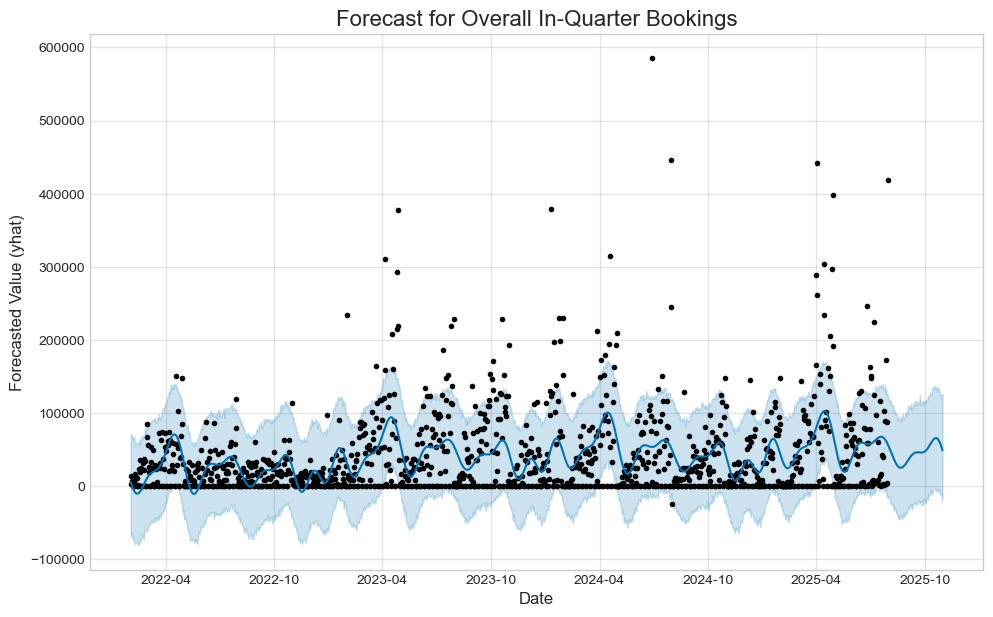

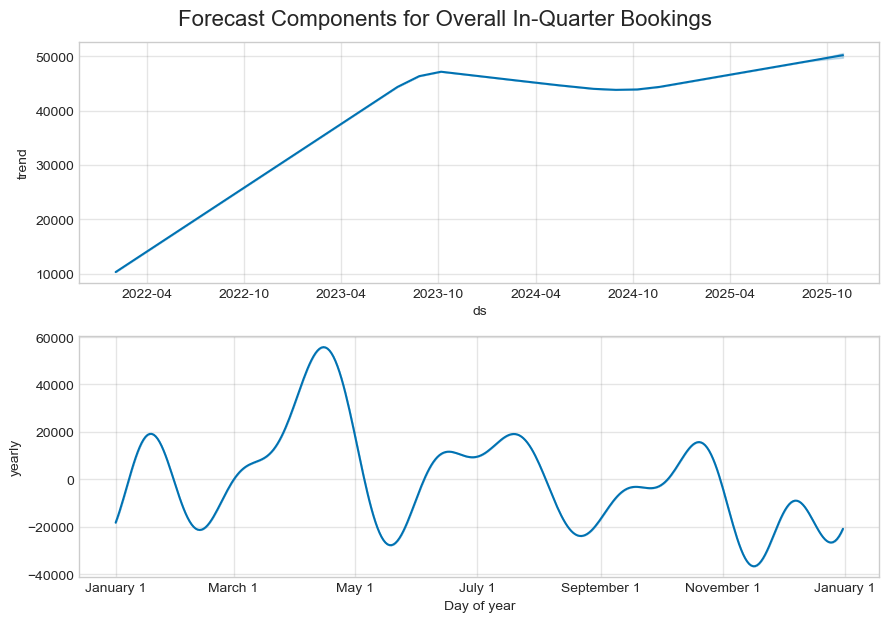

14:44:44 - cmdstanpy - INFO - Chain [1] start processing
14:44:44 - cmdstanpy - INFO - Chain [1] done processing


--- Overall Forecast Details (tail) ---
             ds      yhat  yhat_lower  yhat_upper   y
1364 2025-10-27 58,727.51   -9,367.53  124,980.51 NaN
1365 2025-10-28 56,614.18  -12,977.69  125,315.48 NaN
1366 2025-10-29 54,265.08   -9,237.21  124,069.13 NaN
1367 2025-10-30 51,707.28  -20,666.92  117,978.49 NaN
1368 2025-10-31 48,972.46  -16,266.84  126,204.30 NaN

Running Prophet for: Segment: SMB In-Quarter Bookings
Prophet forecast for Segment: SMB In-Quarter Bookings completed.


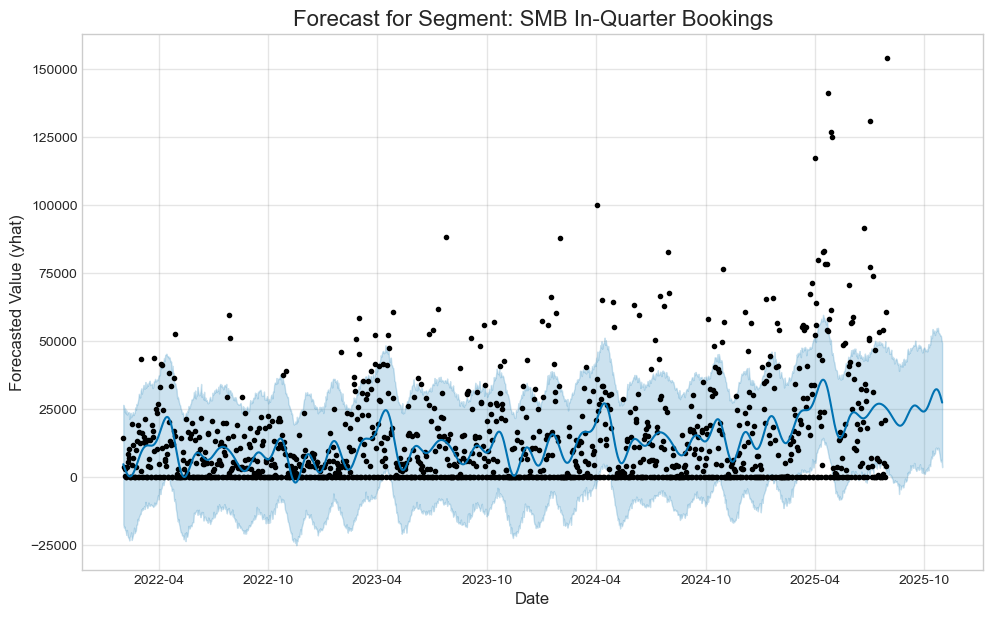

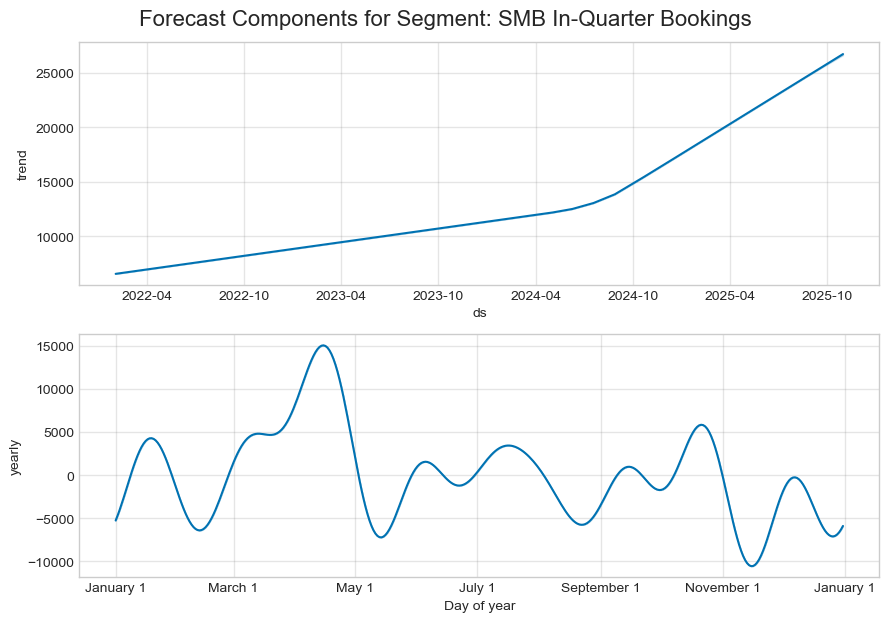

14:44:44 - cmdstanpy - INFO - Chain [1] start processing
14:44:44 - cmdstanpy - INFO - Chain [1] done processing


--- Forecast Details for Segment: SMB (tail) ---
             ds      yhat  yhat_lower  yhat_upper   y
1364 2025-10-27 30,531.32    7,903.60   52,441.90 NaN
1365 2025-10-28 29,865.63    6,213.58   51,908.51 NaN
1366 2025-10-29 29,109.49    5,601.59   51,904.92 NaN
1367 2025-10-30 28,274.24    6,405.51   50,303.27 NaN
1368 2025-10-31 27,372.98    3,642.02   49,318.56 NaN

Running Prophet for: Segment: Mid Market In-Quarter Bookings
Prophet forecast for Segment: Mid Market In-Quarter Bookings completed.


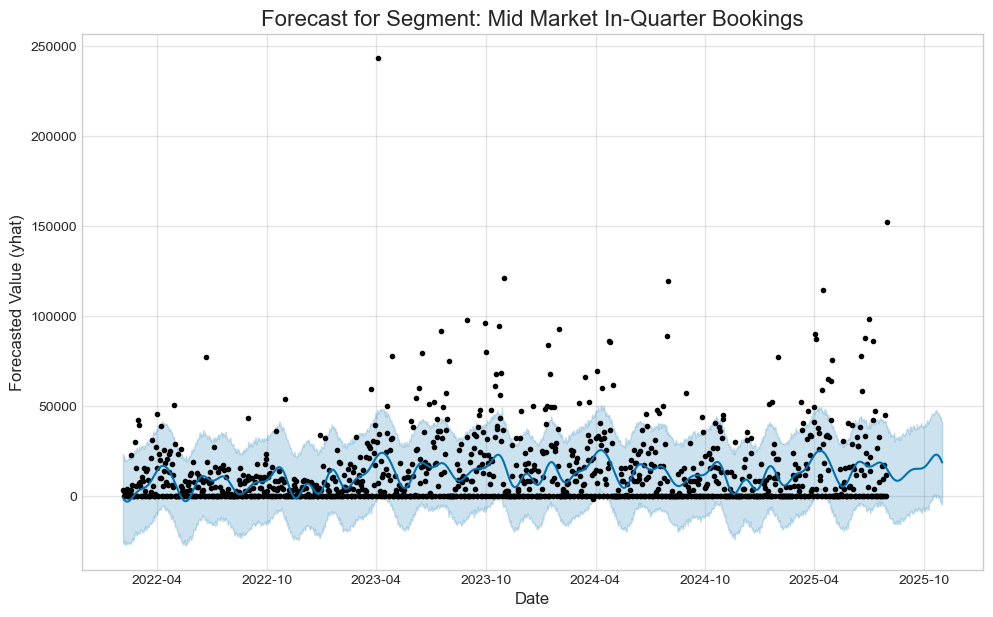

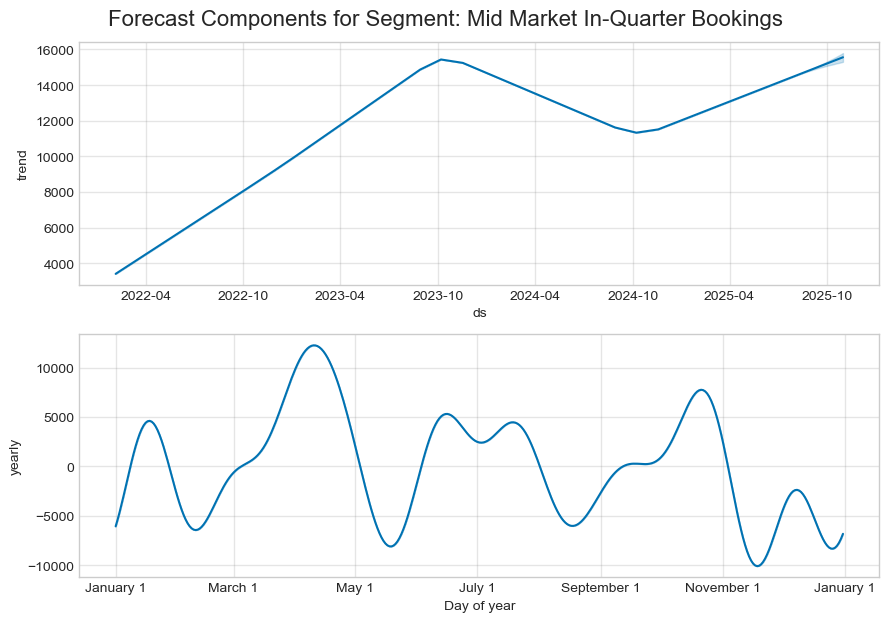

14:44:45 - cmdstanpy - INFO - Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing


--- Forecast Details for Segment: Mid Market (tail) ---
             ds      yhat  yhat_lower  yhat_upper   y
1362 2025-10-27 21,670.95   -1,581.46   44,570.35 NaN
1363 2025-10-28 21,086.45   -3,147.51   43,482.23 NaN
1364 2025-10-29 20,414.63   -3,192.23   44,039.06 NaN
1365 2025-10-30 19,661.95   -4,297.69   41,566.25 NaN
1366 2025-10-31 18,836.53   -4,409.59   41,551.61 NaN

Running Prophet for: Segment: Enterprise In-Quarter Bookings
Prophet forecast for Segment: Enterprise In-Quarter Bookings completed.


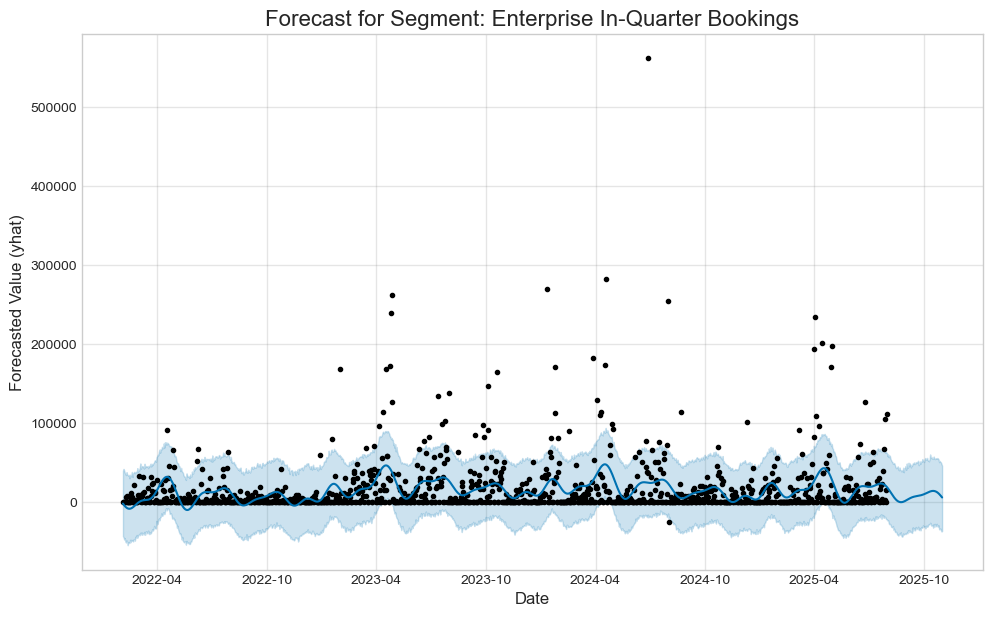

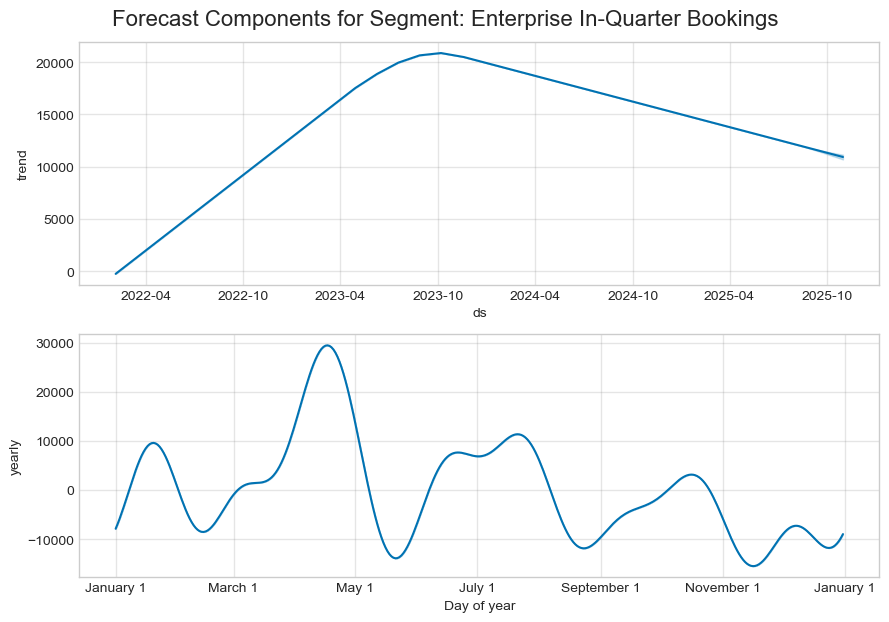

14:44:45 - cmdstanpy - INFO - Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing


--- Forecast Details for Segment: Enterprise (tail) ---
             ds     yhat  yhat_lower  yhat_upper   y
1362 2025-10-27 9,585.98  -34,115.01   52,283.88 NaN
1363 2025-10-28 8,736.32  -33,317.27   50,928.51 NaN
1364 2025-10-29 7,838.77  -35,340.77   50,423.78 NaN
1365 2025-10-30 6,902.43  -37,189.56   48,238.09 NaN
1366 2025-10-31 5,937.25  -36,546.10   46,201.94 NaN

Running Prophet for: Segment: Self Serve In-Quarter Bookings
Prophet forecast for Segment: Self Serve In-Quarter Bookings completed.


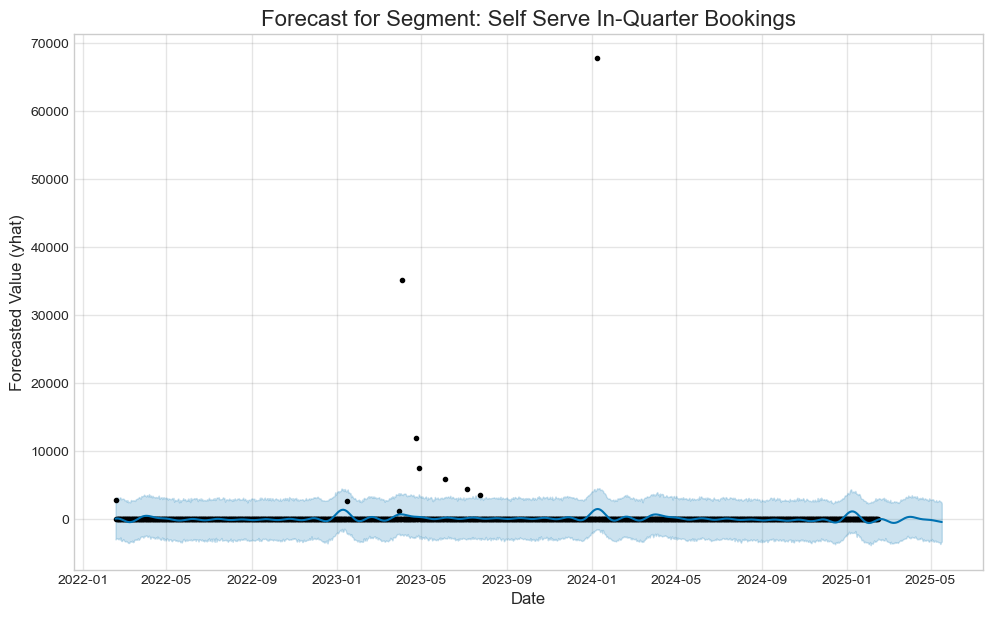

In [ ]:
# ### Prophet Forecasting: Execution & Storing Models/Forecasts

DAYS_TO_FORECAST_PROPHET = 92 # Typical quarter length

all_prophet_models = {}
all_prophet_forecasts = {}

# 1. Overall In-Quarter Bookings Forecast
if not prophet_data_overall.empty:
    model_overall_instance, forecast_overall_df = run_prophet_forecast(
        prophet_data_overall,
        series_descriptive_name="Overall In-Quarter Bookings",
        future_forecast_periods=DAYS_TO_FORECAST_PROPHET
    )
    if model_overall_instance: # Check if model training was successful
        all_prophet_models['overall'] = model_overall_instance
        all_prophet_forecasts['overall'] = forecast_overall_df
        print(f"--- Overall Forecast Details (tail) ---")
        print(forecast_overall_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].tail())
else:
    print("Skipping Overall Prophet forecast as prepared data is empty.")

# 2. In-Quarter Bookings Forecast by Segment
if prophet_data_by_segment: # Check if the dictionary itself is not empty
    for segment_name_key, segment_timeseries_df in prophet_data_by_segment.items():
        if not segment_timeseries_df.empty:
            model_segment_instance, forecast_segment_df = run_prophet_forecast(
                segment_timeseries_df,
                series_descriptive_name=f"Segment: {segment_name_key} In-Quarter Bookings",
                future_forecast_periods=DAYS_TO_FORECAST_PROPHET
            )
            if model_segment_instance:
                all_prophet_models[f'segment_{segment_name_key}'] = model_segment_instance
                all_prophet_forecasts[f'segment_{segment_name_key}'] = forecast_segment_df
                print(f"--- Forecast Details for Segment: {segment_name_key} (tail) ---")
                print(forecast_segment_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].tail())
        else:
            print(f"Skipping Prophet forecast for segment '{segment_name_key}' as its prepared data is empty.")
else:
    print("Skipping Segment-level Prophet forecasts as no segment data was prepared.")

# 3. In-Quarter Bookings Forecast by Bookings Type
if prophet_data_by_booking_type: # Check if the dictionary itself is not empty
    for bt_name_key, bt_timeseries_df in prophet_data_by_booking_type.items():
        if not bt_timeseries_df.empty:
            model_bt_instance, forecast_bt_df = run_prophet_forecast(
                bt_timeseries_df,
                series_descriptive_name=f"Bookings Type: {bt_name_key} In-Quarter Bookings",
                future_forecast_periods=DAYS_TO_FORECAST_PROPHET
            )
            if model_bt_instance:
                all_prophet_models[f'booking_type_{bt_name_key}'] = model_bt_instance
                all_prophet_forecasts[f'booking_type_{bt_name_key}'] = forecast_bt_df
                print(f"--- Forecast Details for Bookings Type: {bt_name_key} (tail) ---")
                print(forecast_bt_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].tail())
        else:
            print(f"Skipping Prophet forecast for bookings type '{bt_name_key}' as its prepared data is empty.")
else:
    print("Skipping Booking Type-level Prophet forecasts as no booking type data was prepared.")

In [ ]:
# ### Prophet Forecasting: Pacing Table Generation & "Unseen" Revenue Analysis

# Determine the start date for "future" pacing tables
# This would typically be the day after the last known data point in the overall series
PACING_TABLE_START_DATE = None
if not prophet_data_overall.empty and 'ds' in prophet_data_overall.columns and not prophet_data_overall['ds'].empty:
    PACING_TABLE_START_DATE = prophet_data_overall['ds'].max() + pd.Timedelta(days=1)
    print(f"Pacing tables will generate forecasts starting from (day after last actual): {PACING_TABLE_START_DATE.strftime('%Y-%m-%d')}")
else:
    print("Warning: Cannot determine PACING_TABLE_START_DATE from prophet_data_overall. Pacing tables might be impacted or skipped.")

def create_pacing_table_from_forecast(prophet_forecast_df, descriptive_name_series, future_pacing_start_date):
    if prophet_forecast_df.empty:
        print(f"Cannot create pacing table for {descriptive_name_series}, input forecast_df is empty.")
        return pd.DataFrame()
    if future_pacing_start_date is None:
        print(f"Cannot create pacing table for {descriptive_name_series}, future_pacing_start_date is None (likely no historical data to base it on).")
        return pd.DataFrame()

    # Filter for future dates based on the start date
    pacing_df_filtered = prophet_forecast_df[prophet_forecast_df['ds'] >= pd.to_datetime(future_pacing_start_date)].copy()
    
    # Ensure required columns from Prophet output are present
    required_prophet_cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    if not all(col in pacing_df_filtered.columns for col in required_prophet_cols):
        print(f"Error: Pacing table for {descriptive_name_series} - forecast DataFrame is missing one or more required Prophet columns: {required_prophet_cols}")
        print("Available columns in filtered forecast:", pacing_df_filtered.columns.tolist())
        return pd.DataFrame()
        
    pacing_df_selected = pacing_df_filtered[required_prophet_cols].copy() # Select only needed columns
    
    # Ensure yhat (forecasted value) and its bounds are not negative (e.g. ARR cannot be negative)
    pacing_df_selected['yhat'] = np.maximum(0, pacing_df_selected['yhat'])
    pacing_df_selected['yhat_lower'] = np.maximum(0, pacing_df_selected['yhat_lower'])
    pacing_df_selected['yhat_upper'] = np.maximum(0, pacing_df_selected['yhat_upper'])
    
    # Calculate cumulative forecast using the (potentially floored) yhat
    pacing_df_selected['Cumulative Forecast (yhat)'] = pacing_df_selected['yhat'].cumsum()
    
    # Rename columns for clarity in the final pacing table
    pacing_df_selected.rename(columns={
        'ds': 'Date', 
        'yhat': 'Forecasted Daily Value', # More generic than ARR if used for other metrics
        'yhat_lower': 'Lower Bound Daily Value',
        'yhat_upper': 'Upper Bound Daily Value'
    }, inplace=True)
    
    print(f"\n--- Pacing Table for {descriptive_name_series} (Next {DAYS_TO_FORECAST_PROPHET} Days) ---")
    if not pacing_df_selected.empty:
        print(pacing_df_selected.head())
        total_forecasted_for_period = pacing_df_selected['Forecasted Daily Value'].sum()
        print(f"Total Forecasted Value for {descriptive_name_series} over next {DAYS_TO_FORECAST_PROPHET} days: {total_forecasted_for_period:,.2f}")
    else:
        print("Pacing table is empty (no future dates or other issue).")

    
    # Plot cumulative forecast for the pacing period
    if not pacing_df_selected.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(pacing_df_selected['Date'], pacing_df_selected['Cumulative Forecast (yhat)'], 
                 label='Cumulative Forecast (yhat)', marker='.', linestyle='-')
        
        # Calculate cumulative sums for lower and upper bounds for the plot
        cumulative_lower_plot = pacing_df_selected['Lower Bound Daily Value'].cumsum()
        cumulative_upper_plot = pacing_df_selected['Upper Bound Daily Value'].cumsum()
        
        plt.fill_between(pacing_df_selected['Date'], 
                         cumulative_lower_plot, 
                         cumulative_upper_plot, 
                         alpha=0.2, label='Cumulative Confidence Interval')
        
        plt.title(f'Cumulative Forecasted Value - {descriptive_name_series}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Cumulative Value', fontsize=12)
        plt.legend()
        plt.grid(True, which='both', linestyle=':')
        plt.tight_layout()
        plt.show()
    
    return pacing_df_selected

# Generate Pacing Tables
if PACING_TABLE_START_DATE:
    if 'overall' in all_prophet_forecasts and not all_prophet_forecasts['overall'].empty:
        pacing_table_overall = create_pacing_table_from_forecast(
            all_prophet_forecasts['overall'], 
            "Overall In-Quarter Bookings", 
            PACING_TABLE_START_DATE
        )

    for forecast_key, forecast_data_df in all_prophet_forecasts.items():
        if forecast_key == 'overall': continue # Already handled

        if not forecast_data_df.empty:
            descriptive_name_for_pacing = forecast_key.replace('_', ' ').title() # e.g. "Segment Enterprise"
            create_pacing_table_from_forecast(
                forecast_data_df, 
                f"{descriptive_name_for_pacing} In-Quarter Bookings", 
                PACING_TABLE_START_DATE
            )
else:
    print("Pacing table generation skipped as PACING_TABLE_START_DATE could not be determined.")
